TODO
- detect_eventsにlegendを
- ts, tl, thをグリッドサーチ
- miniSEED (inv, pickleも) をローカルに落とす
- STA/LTA, 半値幅でスクリーニングしてみる (1〜3ヶ月程度)
- 機械学習で月震検出
- FSOD続き

In [1]:
import json
import os
import pickle
from copy import deepcopy
from datetime import timedelta
from glob import glob
from typing import Optional

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from obspy.clients.fdsn.client import Client
from obspy.core import read
from obspy.core.inventory import read_inventory
from obspy.core.stream import Stream
from obspy.core.utcdatetime import UTCDateTime
from scipy import signal

from src.detect_events import (
    calc_sta_lta,
    get_args_over_sta_lta_threshold,
    get_profile_details,
)
from src.get_seismogram import get_seismogram_iris
from src.pdart_utils import linear_interpolation
from src.plots import plot_current_data, plot_spectrogram
from src.preprocess import reduce_noise, remove_response
from src.utils import get_datetime_ticks


# GET SMQ

In [2]:
def get_datetime_list(s: str):
    date_str, time_str = s.split()

    ret = []
    ret.extend(list(map(int, date_str.split("-"))))
    ret.extend(list(map(int, time_str.split(":"))))
    return ret

In [3]:
with open("/Users/imagawa/Desktop/実験データ/HFT_datetime/HFT_datetime.json", "r") as f:
    hft_datetime = json.load(f)

In [4]:
with open("logs/log_get_smq.txt", "a") as f:
    for key, value in hft_datetime.items():
        print(f"[{key}] -> [START] ", end="", file=f)

        station = "S" + key[1:3]
        filename = station + "_" + value.replace(" ", "_").replace(":", "-") + ".pkl"
        center_datetime = get_datetime_list(value)
        center_datetime = UTCDateTime(*center_datetime)
        starttime, endtime = (
            center_datetime - timedelta(hours=12),
            center_datetime + timedelta(hours=12),
        )
        print(">>>>>>>>>>", end="", file=f)

        st = get_seismogram_iris(
            starttime=starttime,
            endtime=endtime,
            station=station,
        )
        if st is None:
            print(" [ERROR]", file=f)
            continue
        with open(f"./pickles_smq/SHZ/1_raw/{filename}", "wb") as p:
            pickle.dump(st, p)
        print(">>>>>>>>>>", end="", file=f)

        st = remove_response(
            stream=st,
            starttime=starttime,
            endtime=endtime,
            station=station,
        )
        if st is None:
            print(" [ERROR]", file=f)
            continue
        with open(f"./pickles_smq/SHZ/2_remove_response/{filename}", "wb") as p:
            pickle.dump(st, p)
        print(">>>>>>>>>> [END]", file=f)


========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detailed response of server:



========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detailed response of server:



========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detailed response of server:



========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detailed response of server:



========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detailed response of server:



========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detailed response of server:



========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detailed response of server:



========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detailed response of server:



========== ERROR ==========

No data available for request.
HTTP Status code: 204
Detail

In [5]:
files = sorted(glob("pickles_smq/SHZ/2_remove_response/*"))
with open("logs/log_get_smq.txt", "a") as f:
    for file in files:
        filename = file.split("/")[-1]
        print(f"[{filename}] -> [START] ", end="", file=f)

        with open(file, "rb") as p:
            st = pickle.load(p)
        if st is None:
            print(" [ERROR]", file=f)
            continue
        print(">>>>>>>>>>", end="", file=f)

        try:
            st = reduce_noise(st)
        except Exception as e:
            print(" [ERROR]", file=f)
            print(e)
            continue
        print(">>>>>>>>>>", end="", file=f)

        with open(f"pickles_smq/SHZ/3_reduce_noise/{filename}", "wb") as p:
            pickle.dump(st, p)
        print(">>>>>>>>>> [END]", file=f)

# GET SIGNALS

In [9]:
station = "S16"
with open("logs/log_get_signals.txt", "a") as f:
    # init
    starttime = UTCDateTime(1975, 1, 1)
    endtime = starttime + timedelta(days=1)

    for i in range(100):
        filename = station + "_" + starttime.strftime("%Y-%m-%d") + ".pkl"
        print(f"[{filename}] -> [START] ", end="", file=f)

        st = get_seismogram_iris(
            starttime=starttime,
            endtime=endtime,
            station=station,
        )
        if st is None:
            print(" [ERROR]", file=f)
            continue
        with open(f"./pickles/SHZ/1_raw/{filename}", "wb") as p:
            pickle.dump(st, p)
        print(">>>>>>>>>>", end="", file=f)

        st = remove_response(
            stream=st,
            starttime=starttime,
            endtime=endtime,
            station=station,
        )
        if st is None:
            print(" [ERROR]", file=f)
            continue
        with open(f"./pickles/SHZ/2_remove_response/{filename}", "wb") as p:
            pickle.dump(st, p)
        print(">>>>>>>>>> [END]", file=f)

        starttime = starttime + timedelta(days=1)
        endtime = endtime + timedelta(days=1)

In [2]:
files = sorted(glob("pickles/SHZ/2_remove_response/*"))
with open("logs/log_get_signals.txt", "a") as f:
    for file in files:
        filename = file.split("/")[-1]
        print(f"[{filename}] -> [START] ", end="", file=f)

        with open(file, "rb") as p:
            st = pickle.load(p)
        if st is None:
            print(" [ERROR]", file=f)
            continue
        print(">>>>>>>>>>", end="", file=f)

        try:
            st = reduce_noise(st)
        except Exception as e:
            print(" [ERROR]", file=f)
            print(e)
            continue
        print(">>>>>>>>>>", end="", file=f)

        with open(f"pickles/SHZ/3_reduce_noise/{filename}", "wb") as p:
            pickle.dump(st, p)
        print(">>>>>>>>>> [END]", file=f)
        

operands could not be broadcast together with shapes (271,) (3180,) 


# SAVE NOISE REDUCED DATA

In [ ]:
files = sorted(glob("pickles_smq/SHZ/3_reduce_noise/*"))

for file in files:
    filename = file.split("/")[-1].replace(".pkl", "") + ".png"
    with open(file, "rb") as p:
        st = pickle.load(p)
    plot_current_data(st, waveform_ylim=1.2e-7, filename=f"plots_smq/plot_current_data/ylim_1/{filename}")
    # plot_current_data(st, waveform_ylim=6e-7, filename=f"plots_smq/plot_current_data/ylim_5/{filename}")

# SAVE SPECTROGRAM

In [4]:
files = sorted(glob("pickles_smq/SHZ/3_reduce_noise/*"))

for file in files:
    filename = file.split("/")[-1].replace(".pkl", "") + ".png"
    with open(file, "rb") as p:
        st = pickle.load(p)
    plot_spectrogram(st, waveform_ylim=1.2e-7, filename=f"plots_smq/plot_spectrogram/ylim_1/{filename}")
    plot_spectrogram(st, waveform_ylim=6e-7, filename=f"plots_smq/plot_spectrogram/ylim_5/{filename}")

# GRID SEARCH (STA/LTA)

In [2]:
import json
import os
import pickle
from copy import deepcopy
from datetime import timedelta
from glob import glob
from typing import Optional

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from obspy.clients.fdsn.client import Client
from obspy.core import read
from obspy.core.inventory import read_inventory
from obspy.core.stream import Stream
from obspy.core.utcdatetime import UTCDateTime
from scipy import signal

from src.detect_events import (
    calc_sta_lta,
    get_args_over_sta_lta_threshold,
    get_profile_details,
)
from src.get_seismogram import get_seismogram_iris
from src.pdart_utils import linear_interpolation
from src.plots import plot_current_data, plot_spectrogram
from src.preprocess import reduce_noise, remove_response
from src.utils import get_datetime_ticks

tl_gs = [1200, 1800, 2400]
ts_gs = [100, 300, 600]
# th_gs = [2, 3, 5, 10]

files = sorted(glob("pickles_smq/SHZ/3_reduce_noise/*"))

i = 71
print(len(files))
for file in [files[i], files[i+1]]:
    print(f"START: {i}")

    filename_prefix = file.split("/")[-1].replace(".pkl", "")
    with open(file, "rb") as p:
        st = pickle.load(p)

    for tl in tl_gs:
        for ts in ts_gs:
            try:
                sta_lta = calc_sta_lta(
                    stream=st,
                    tl_sec=tl,
                    ts_sec=ts,
                )
                start_args, end_args = get_args_over_sta_lta_threshold(
                    stream=st,
                    input_sta_lta=sta_lta,
                    sta_lta_threshold=2, # TODO: fix
                    run_length_threshold=st[0].stats.sampling_rate,  # 1 sec
                    plot_title=f"{st[0].stats.station}, {st[0].stats.channel}, tl={tl}, ts={ts}",
                    plot_filename="plots_smq/plot_get_args_over_sta_lta_threshold/"
                    + filename_prefix
                    + f"_tl-{tl}_ts-{ts}.png",
                )
            except:
                continue

    print(f"DONE: {i}")
    i += 1


71


IndexError: list index out of range

# SMQ LENGTH

In [2]:
files = sorted(glob("pickles_smq/SHZ/3_reduce_noise/*"))

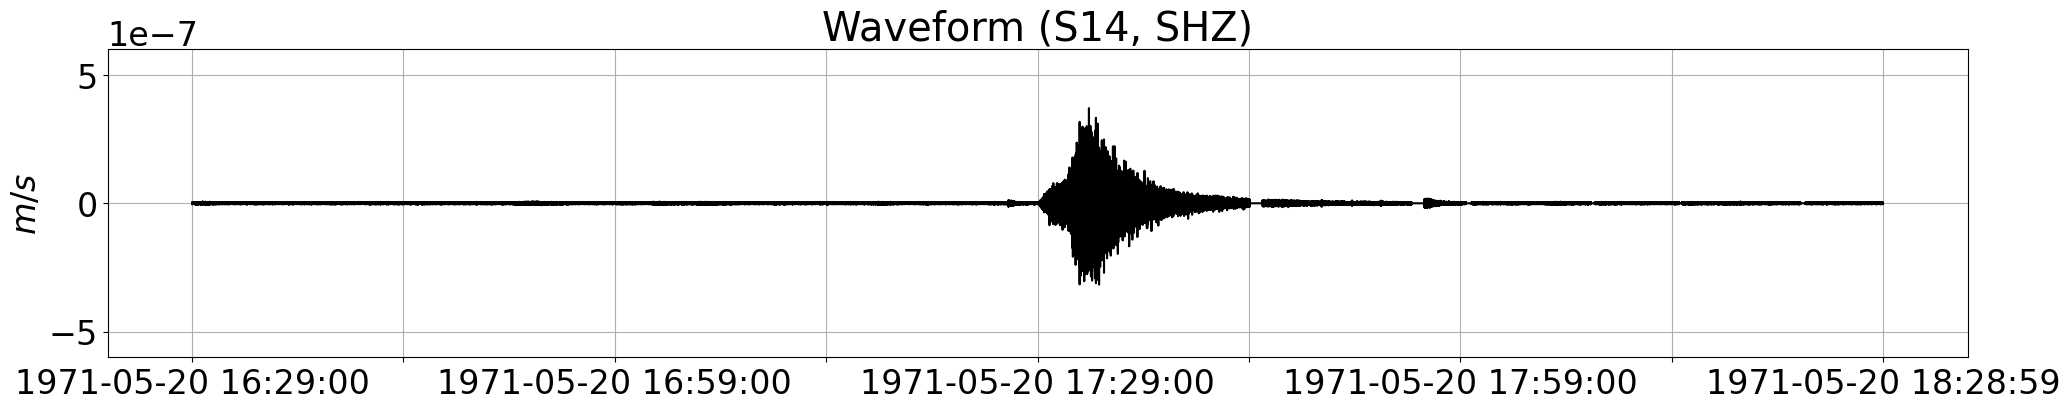

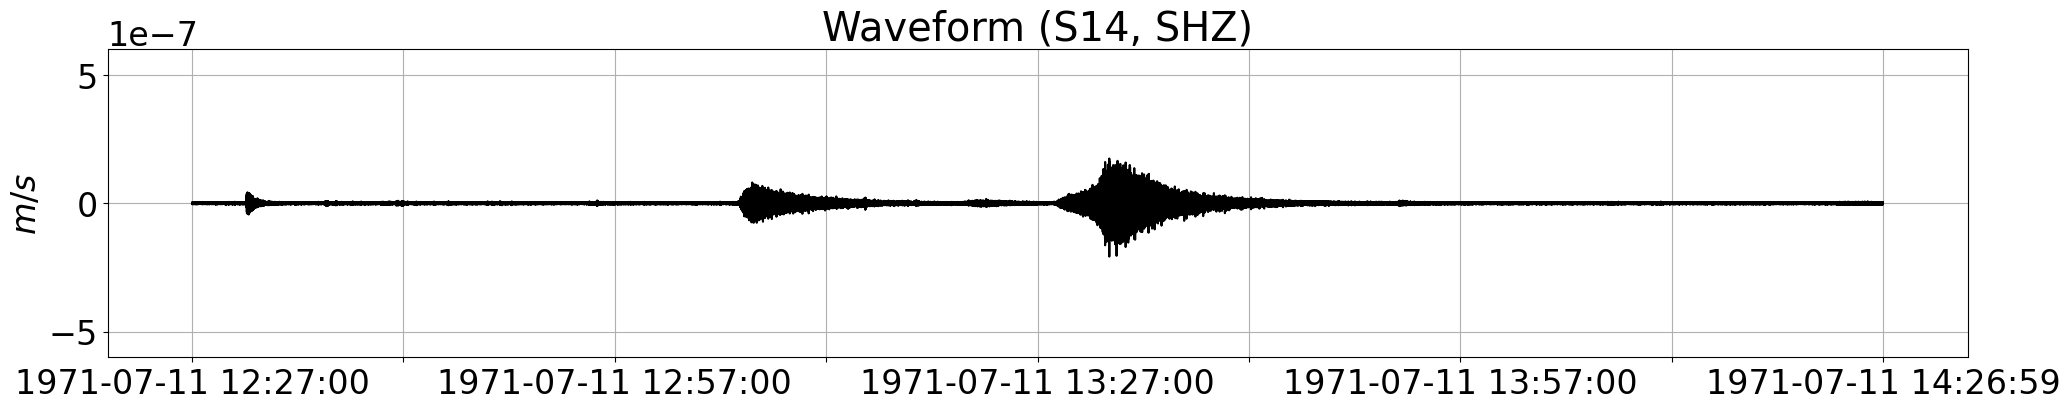

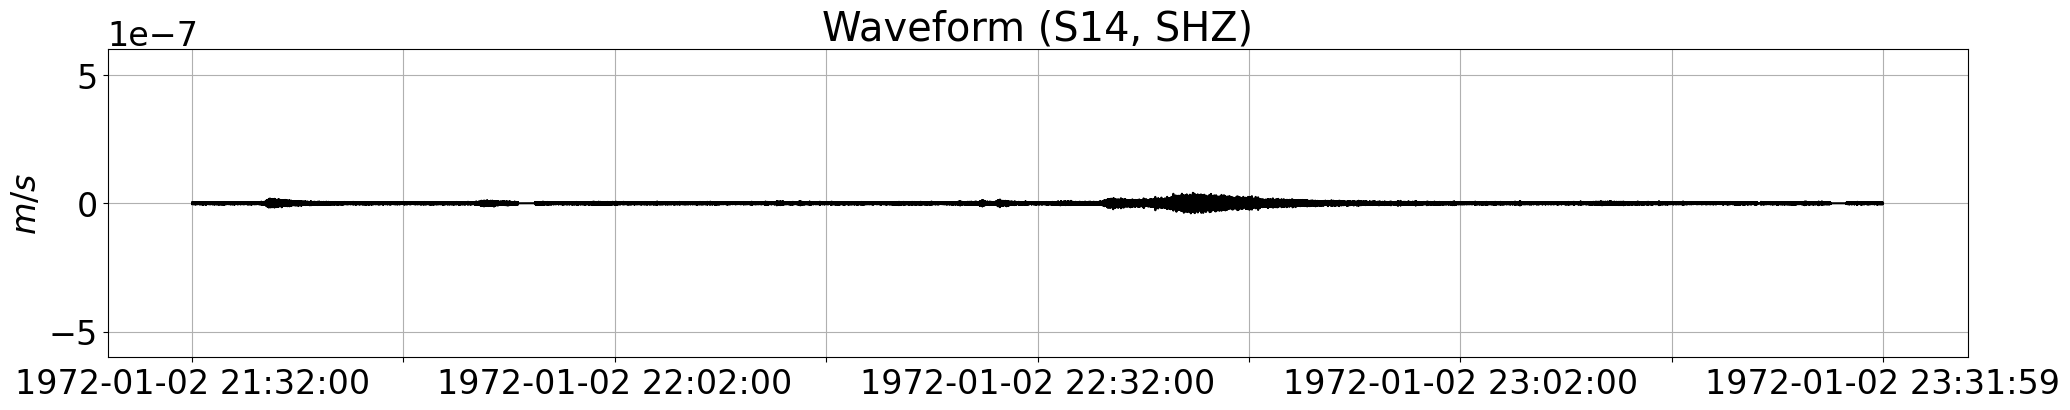

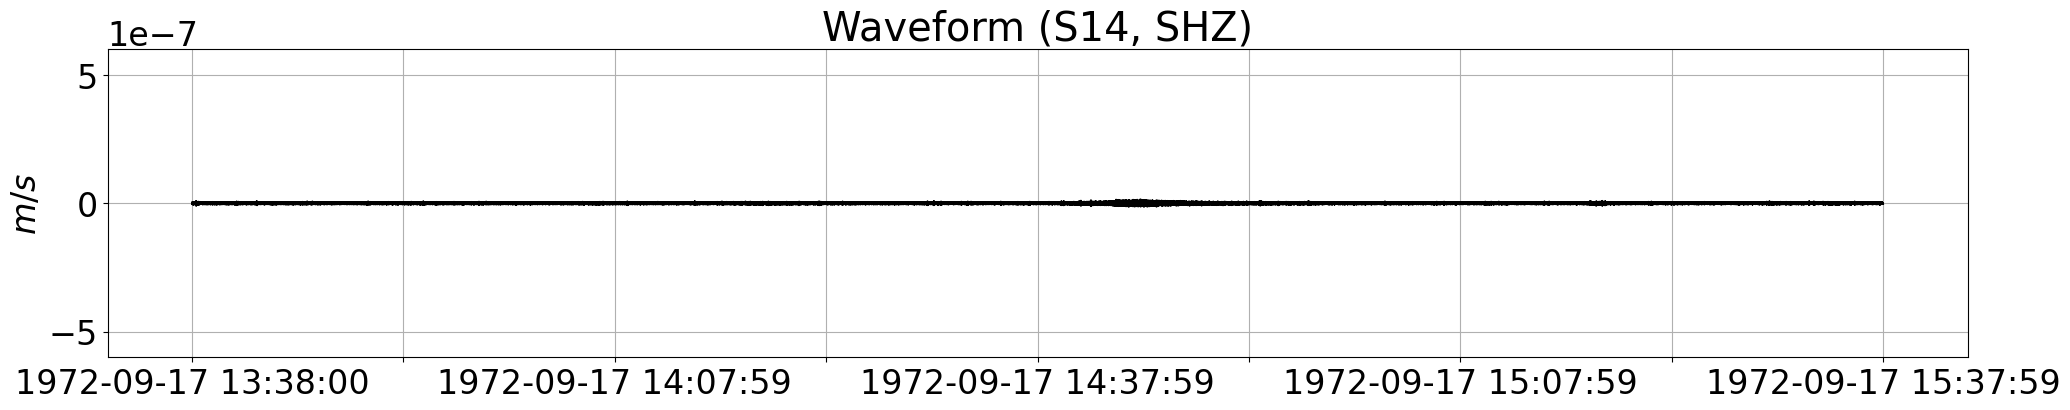

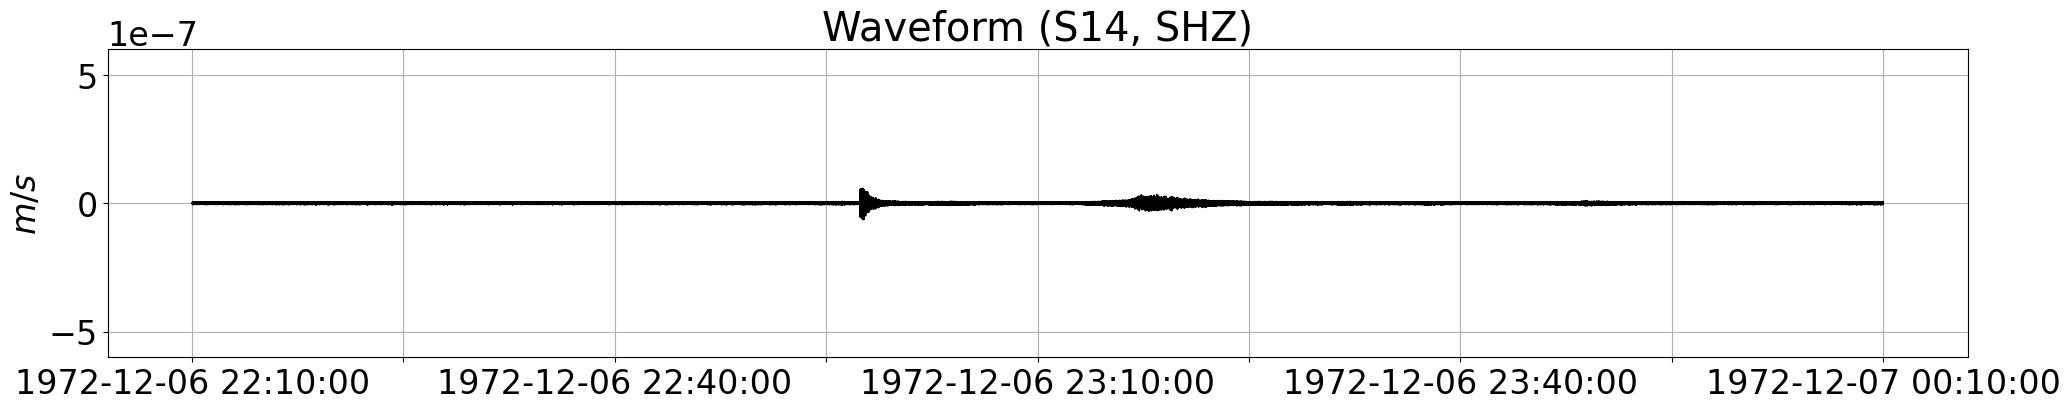

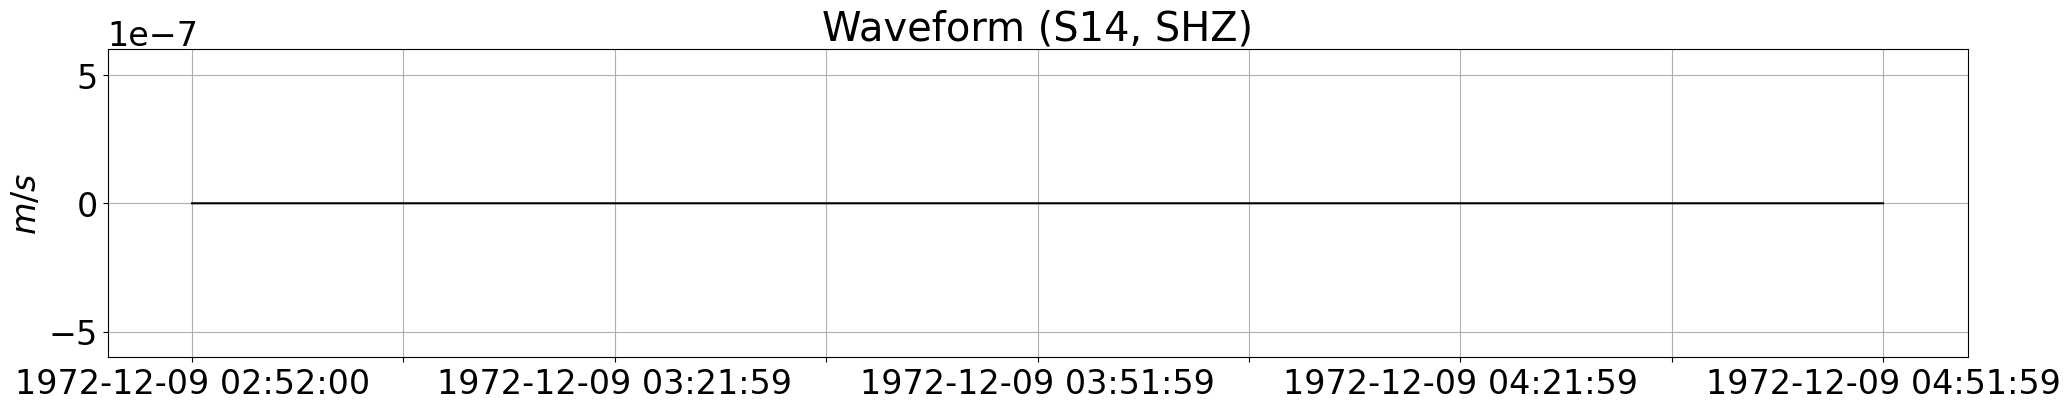

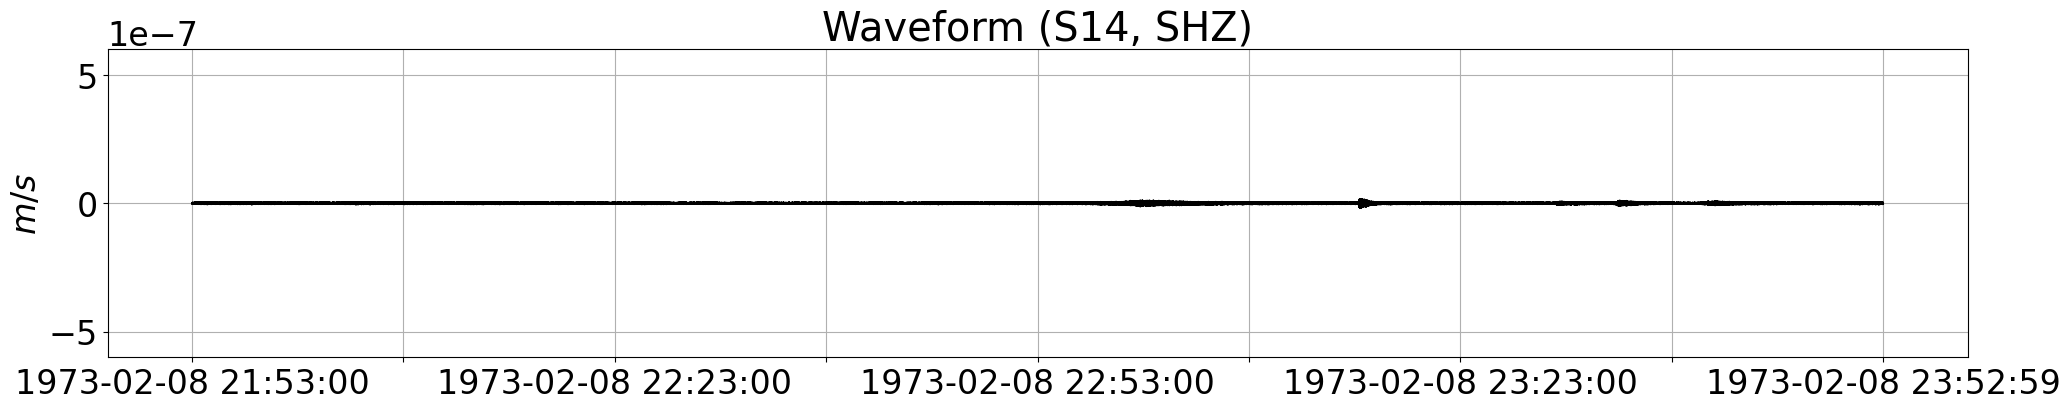

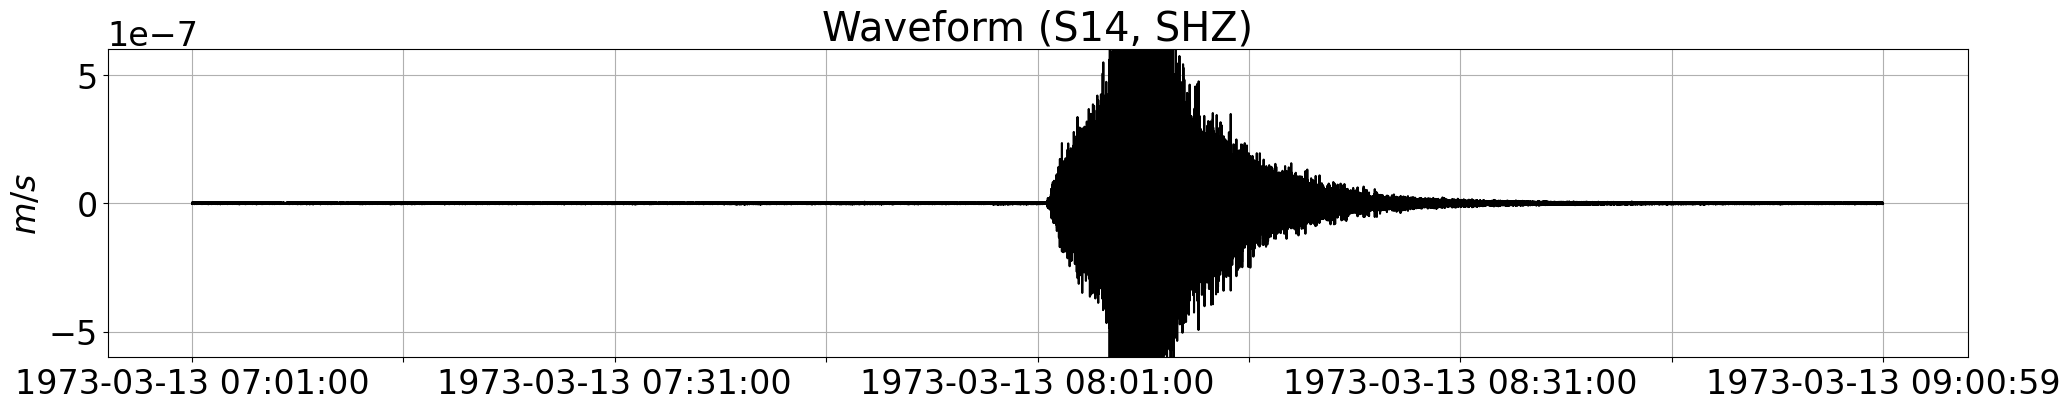

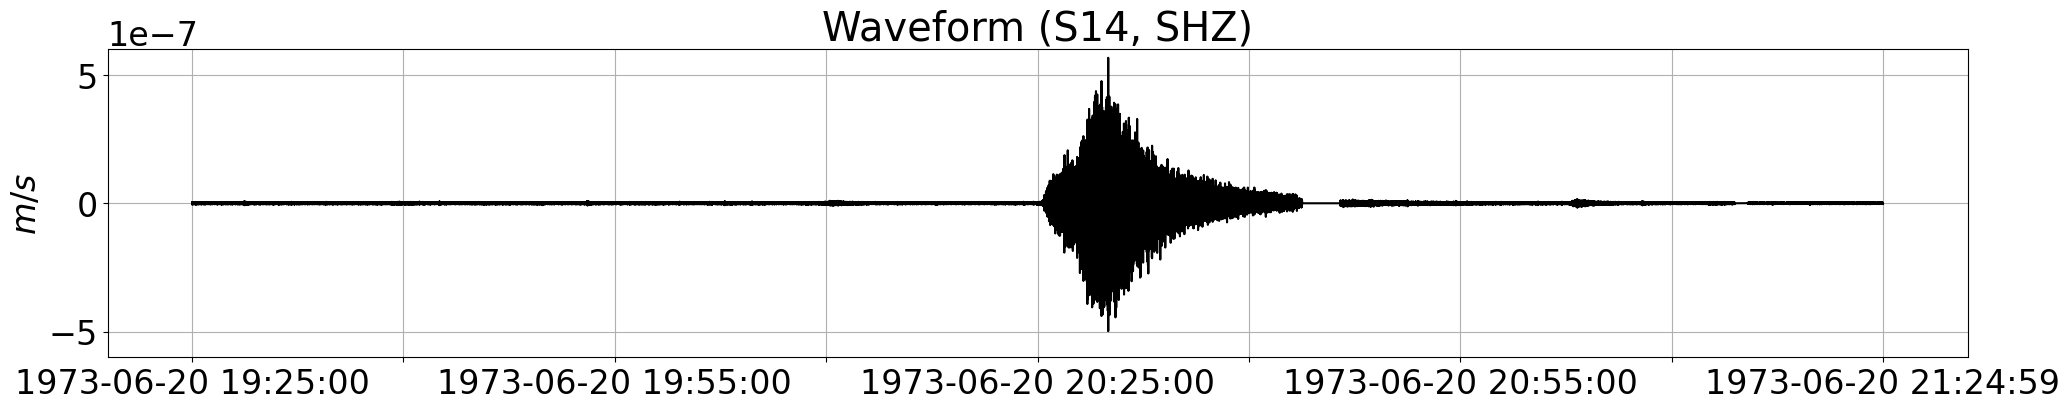

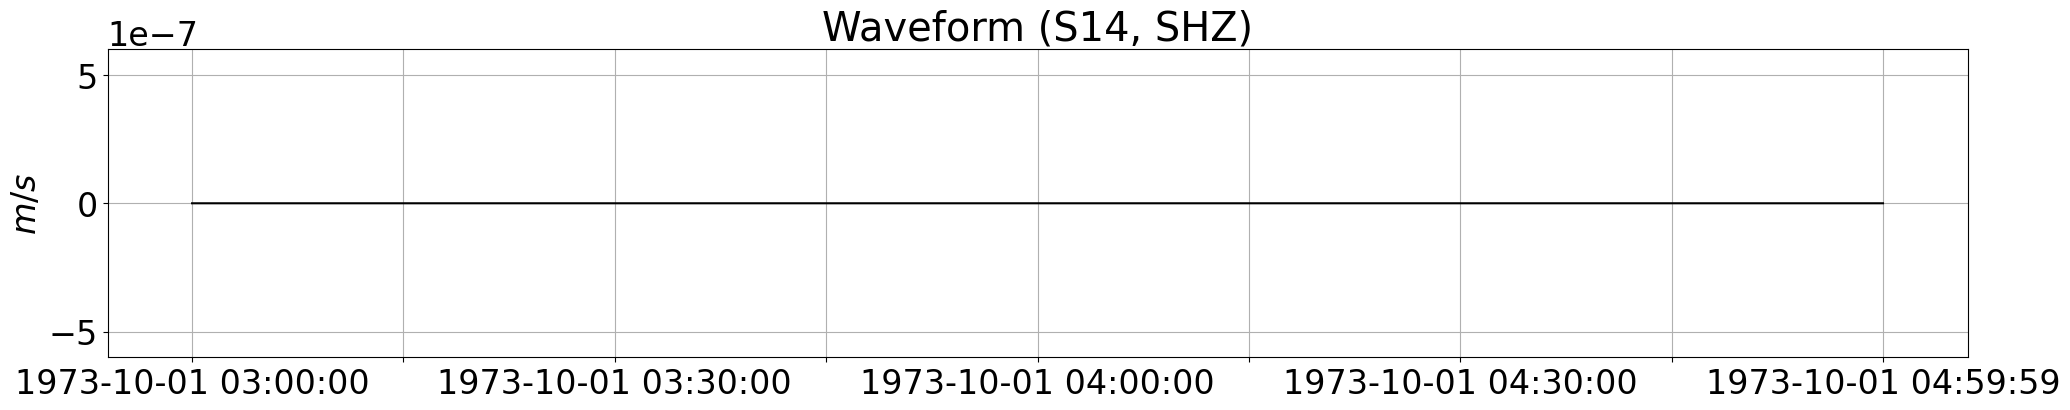

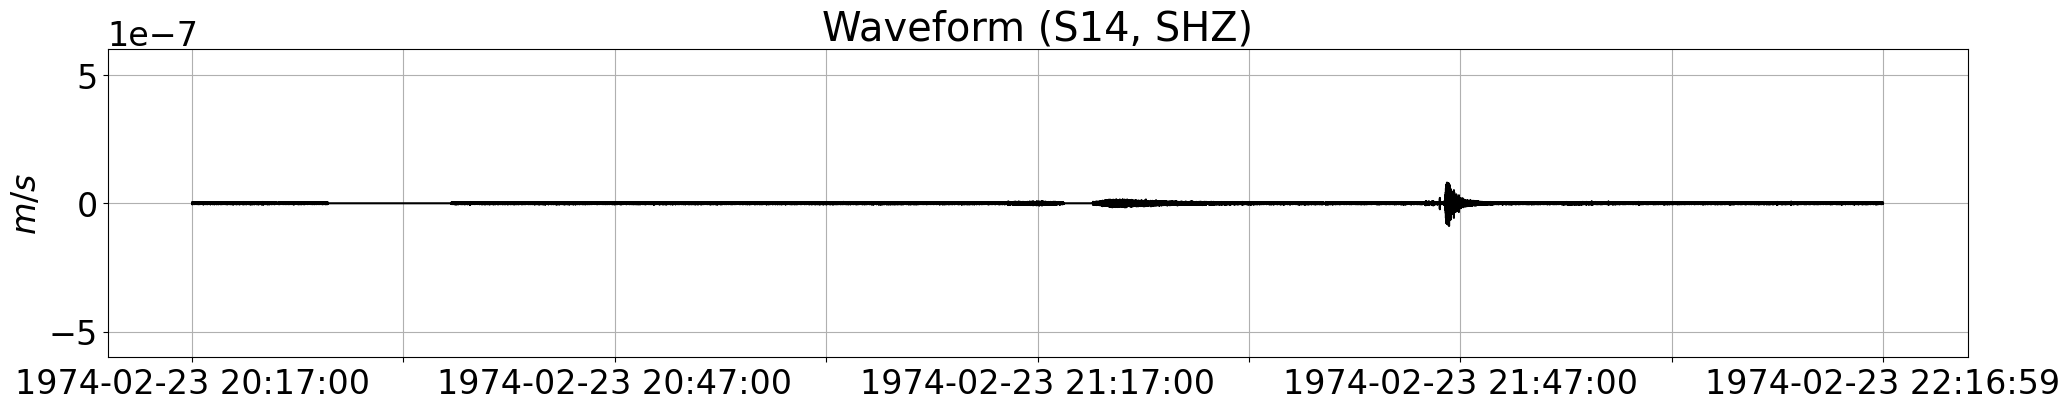

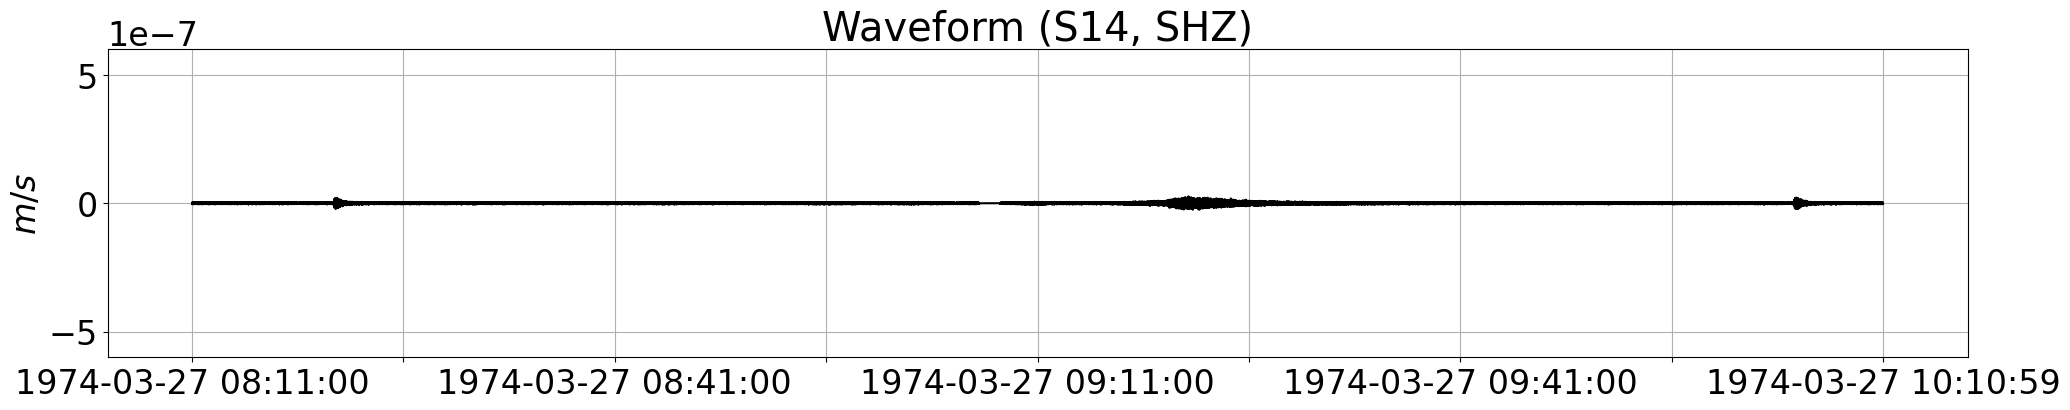

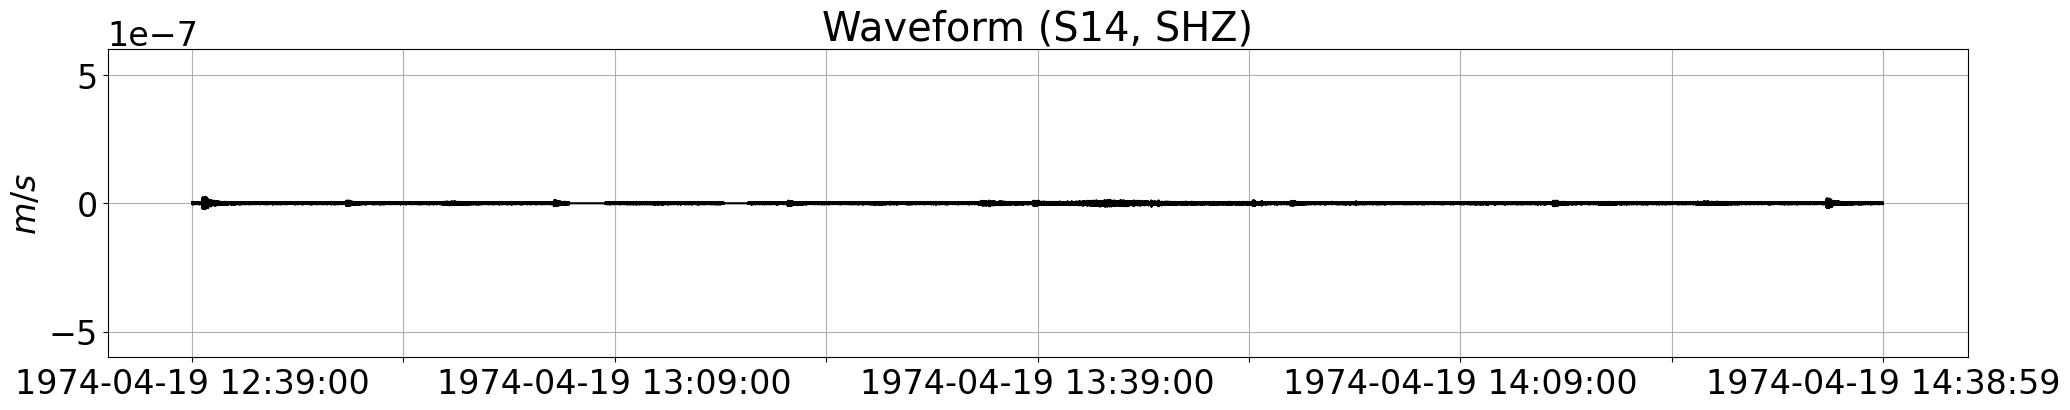

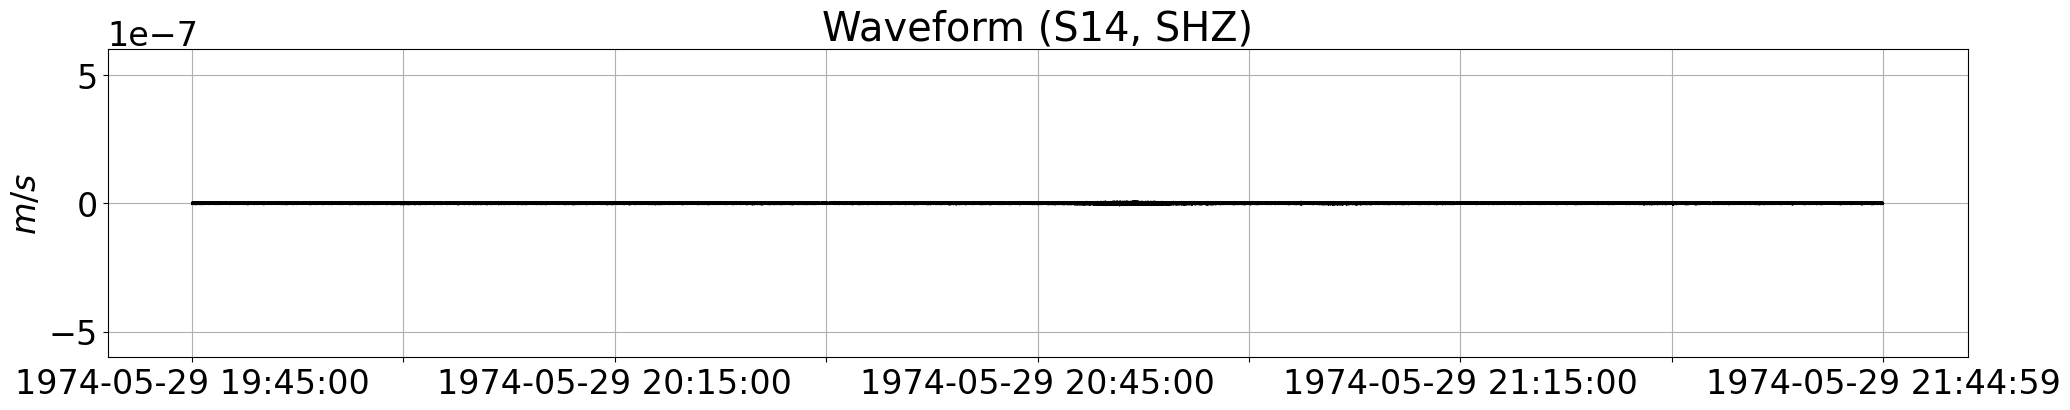

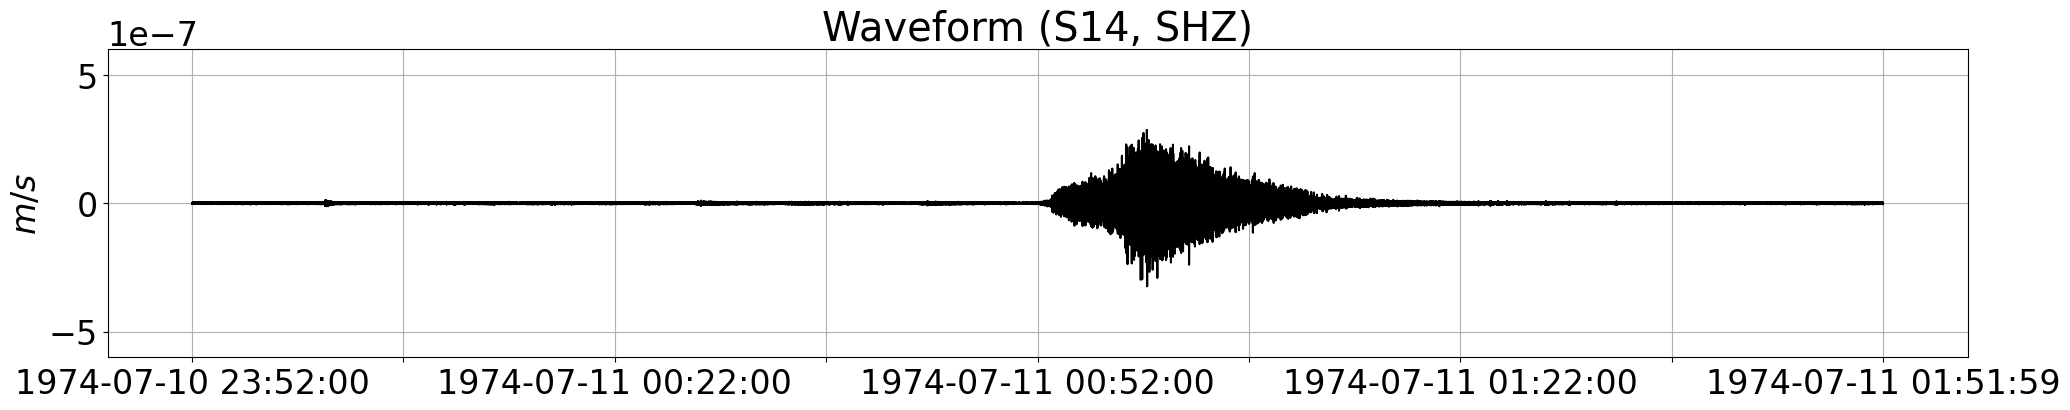

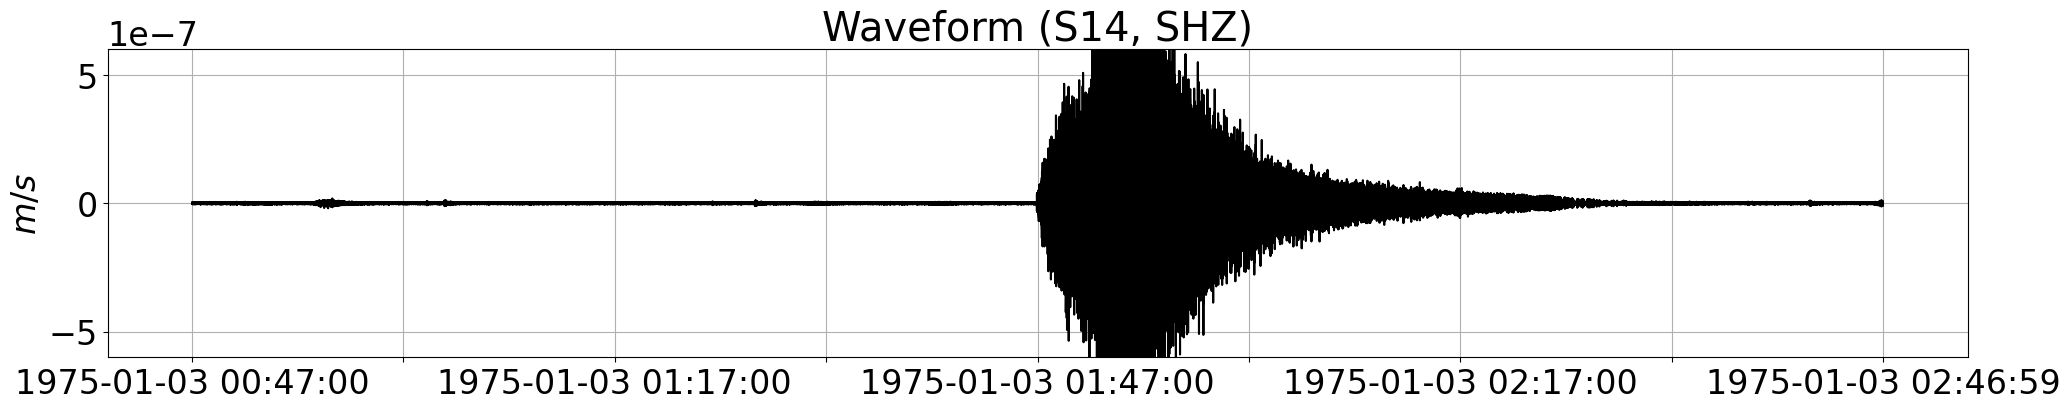

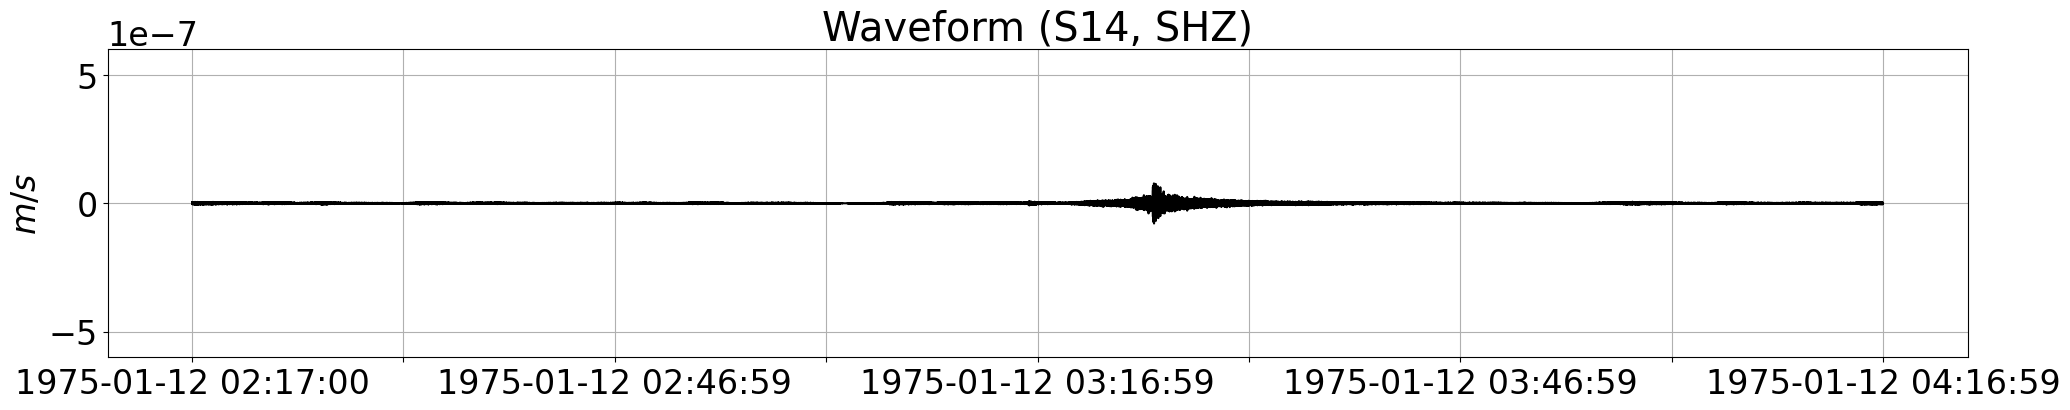

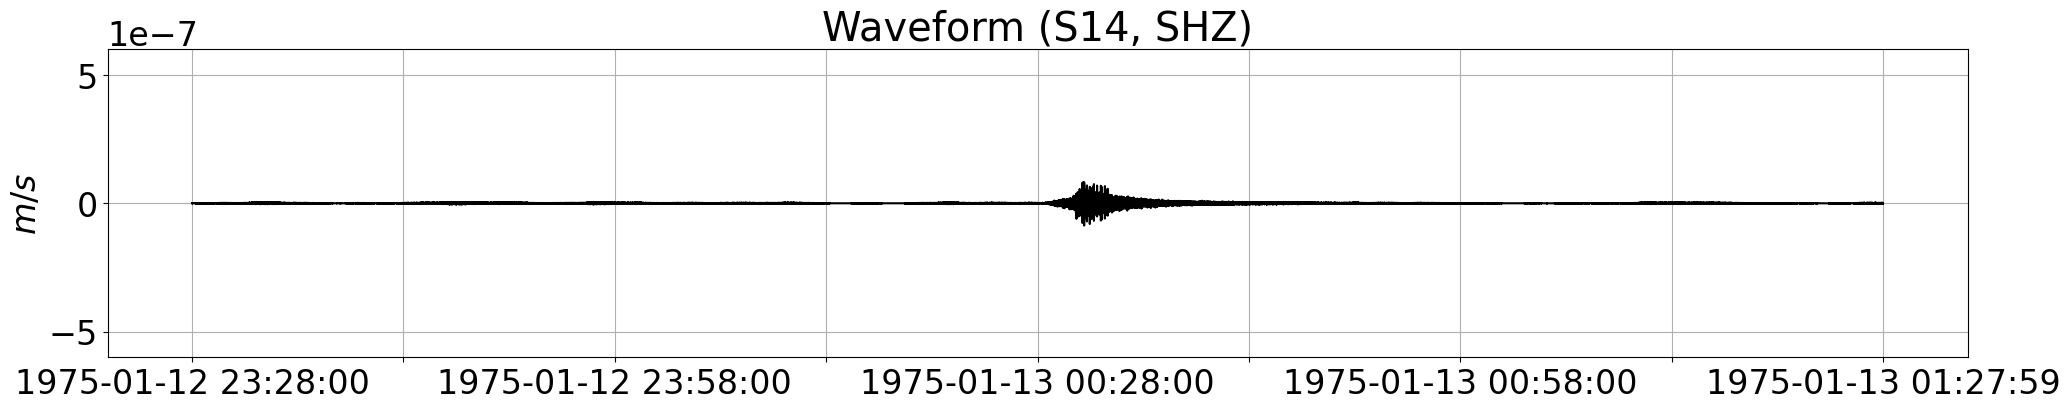

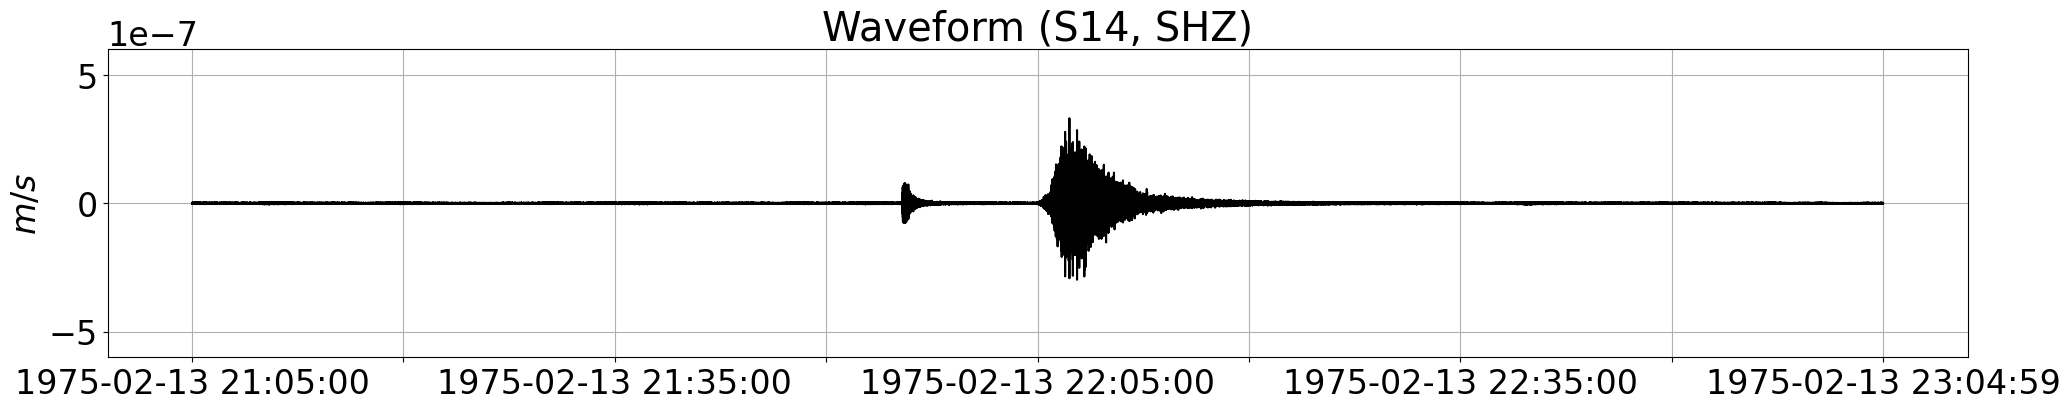

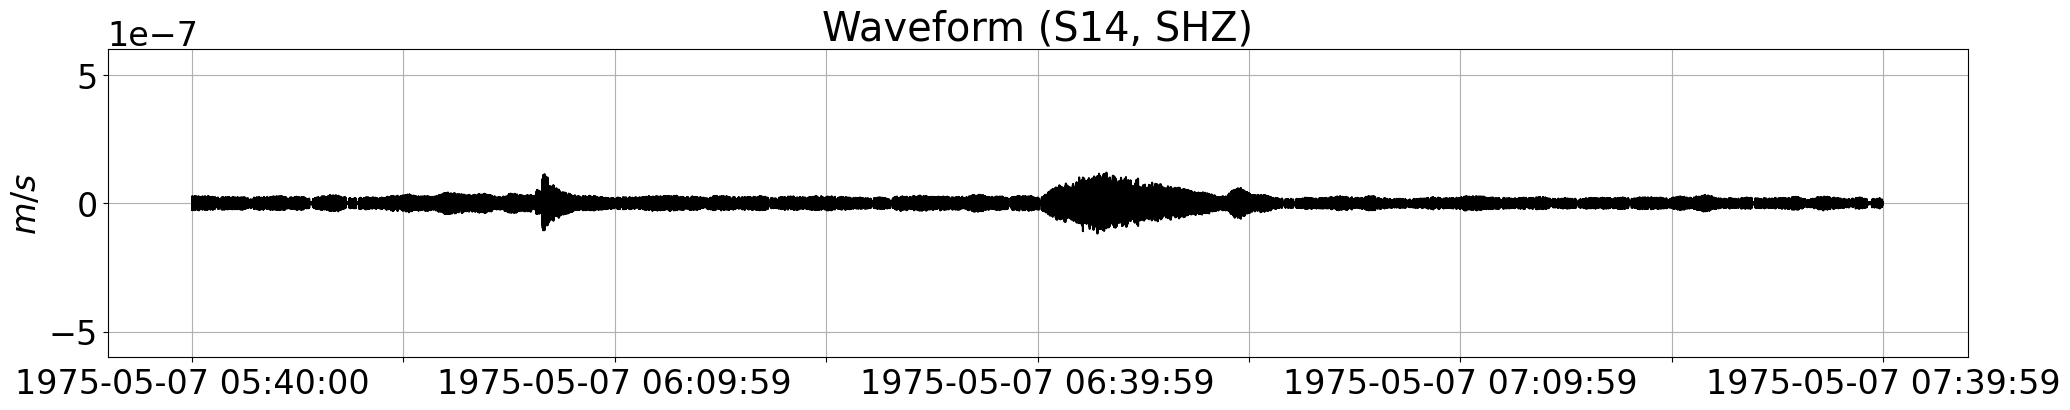

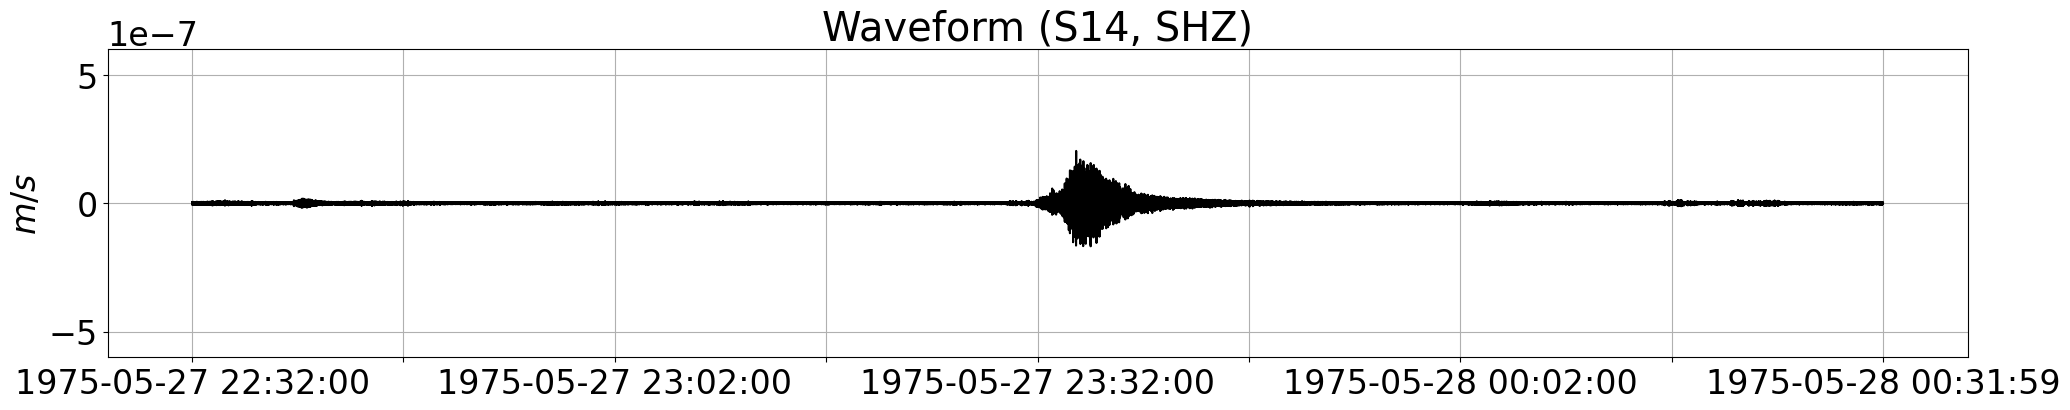

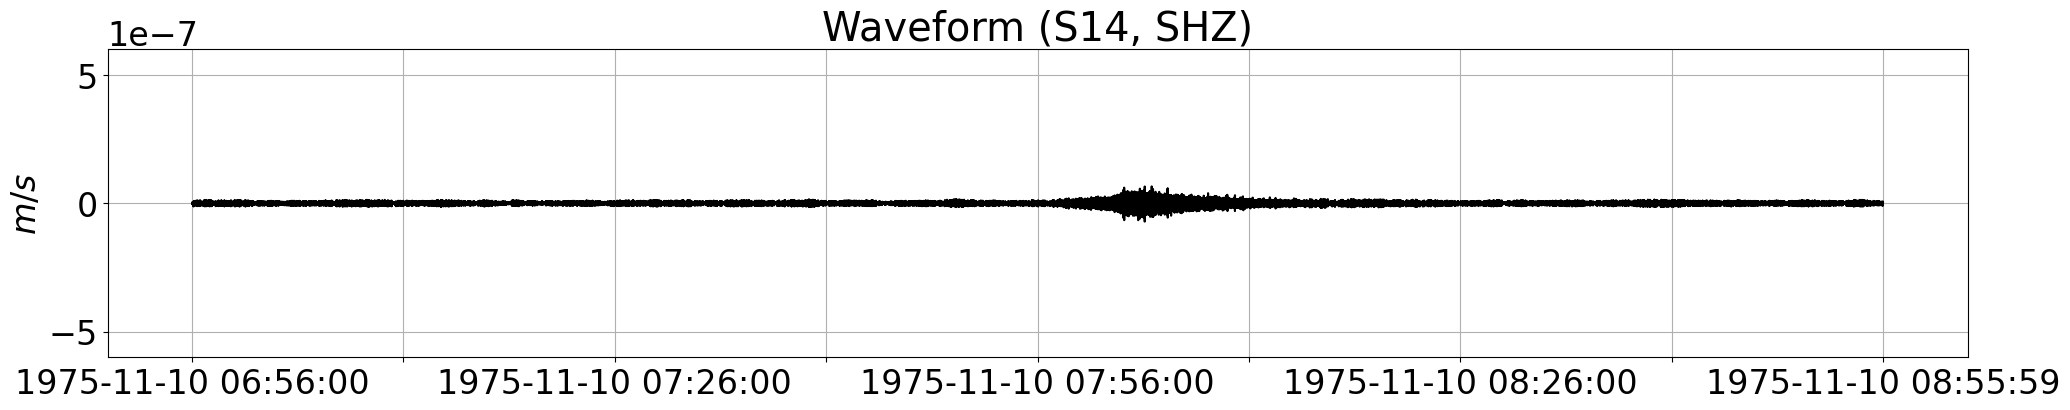

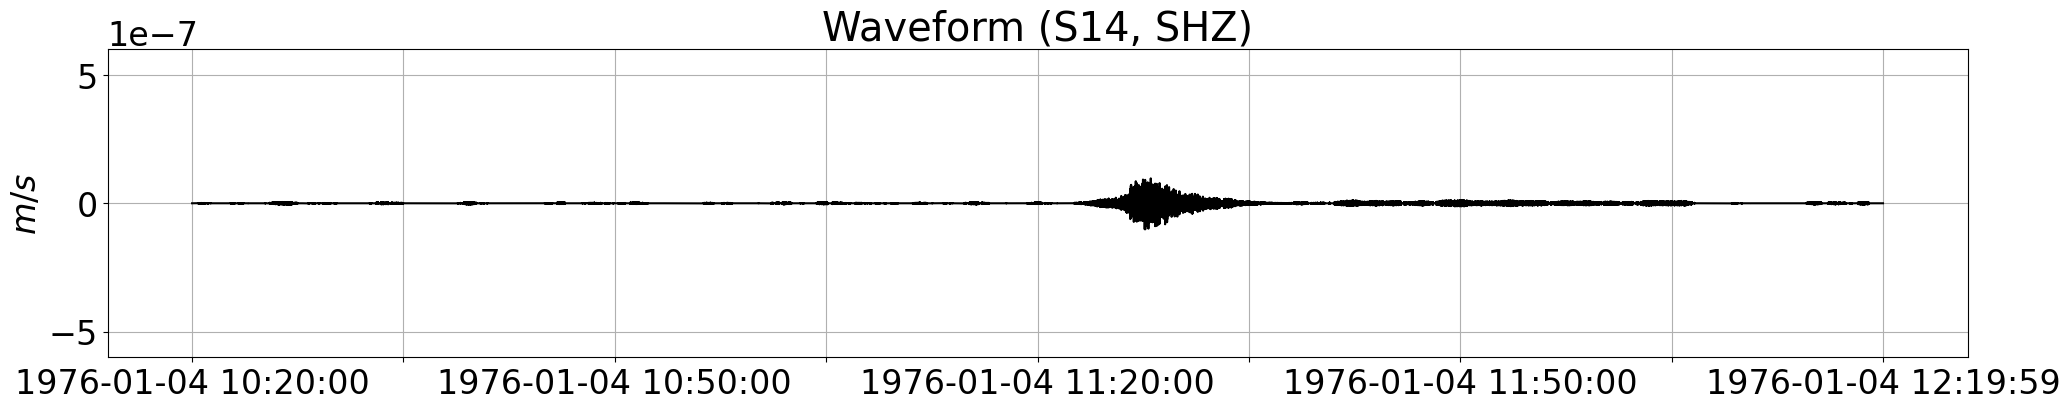

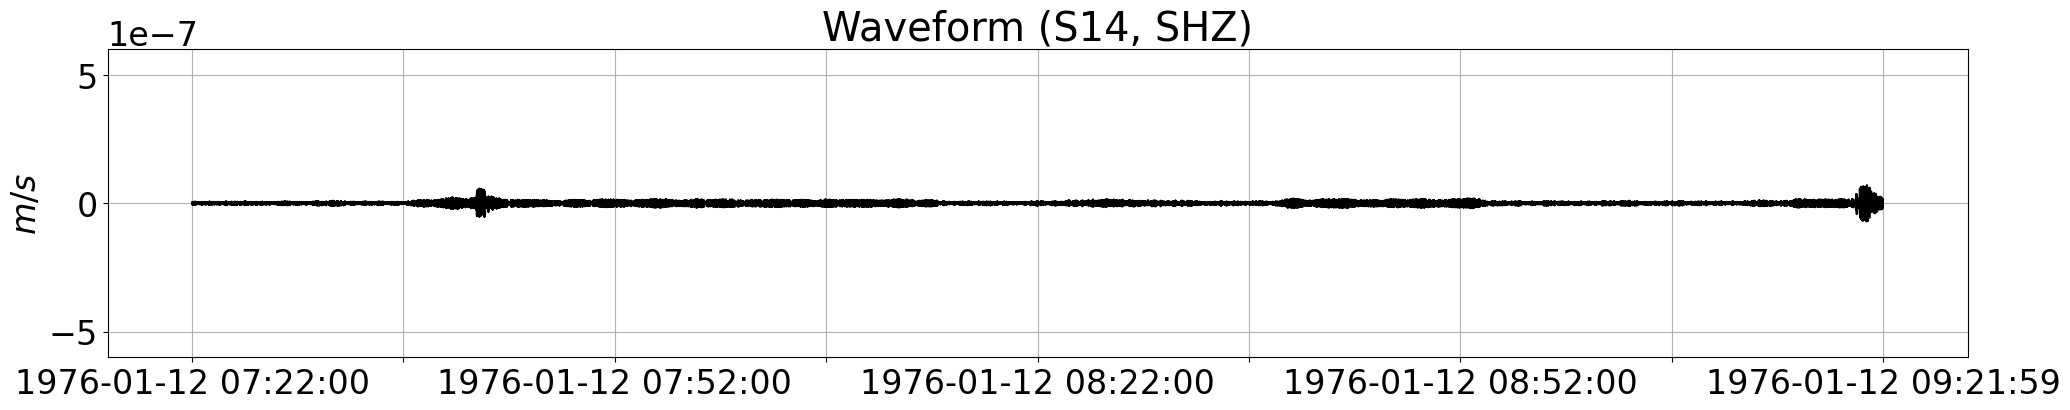

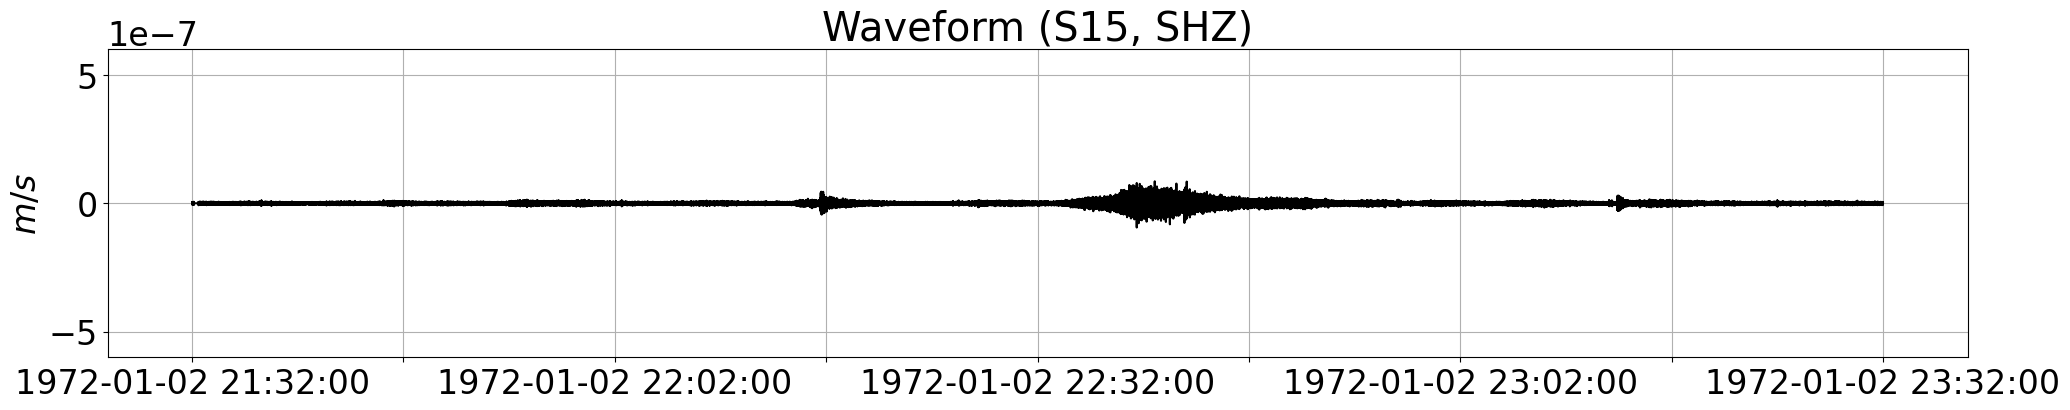

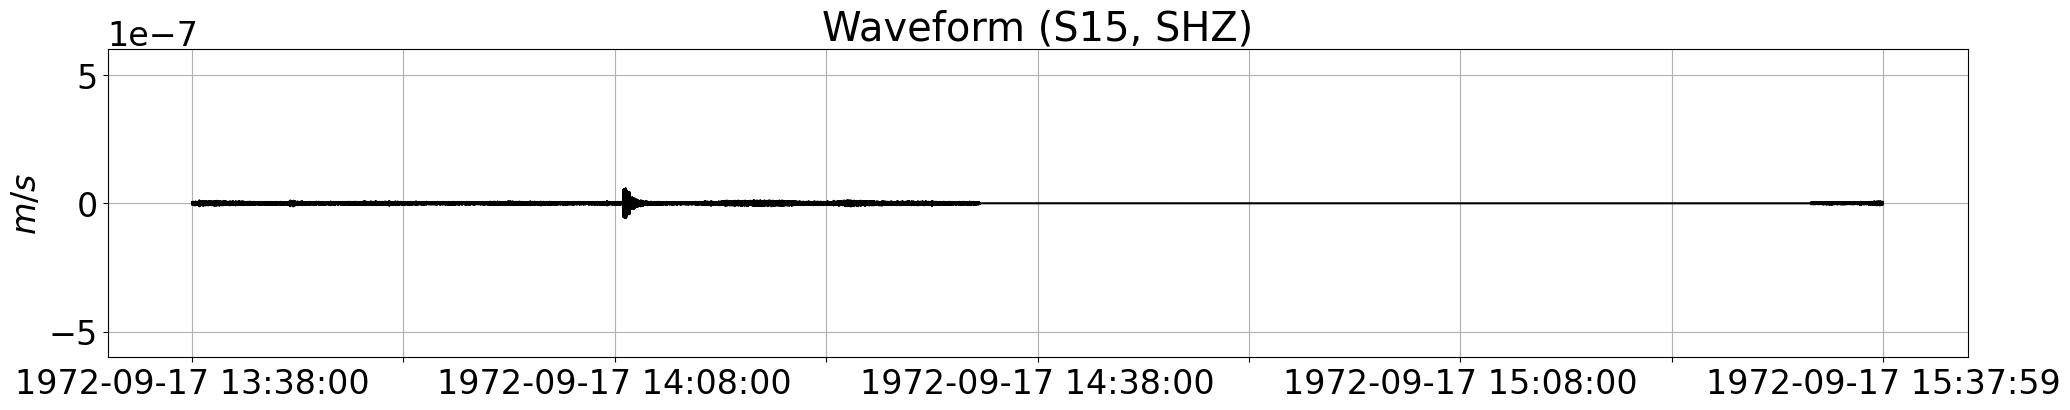

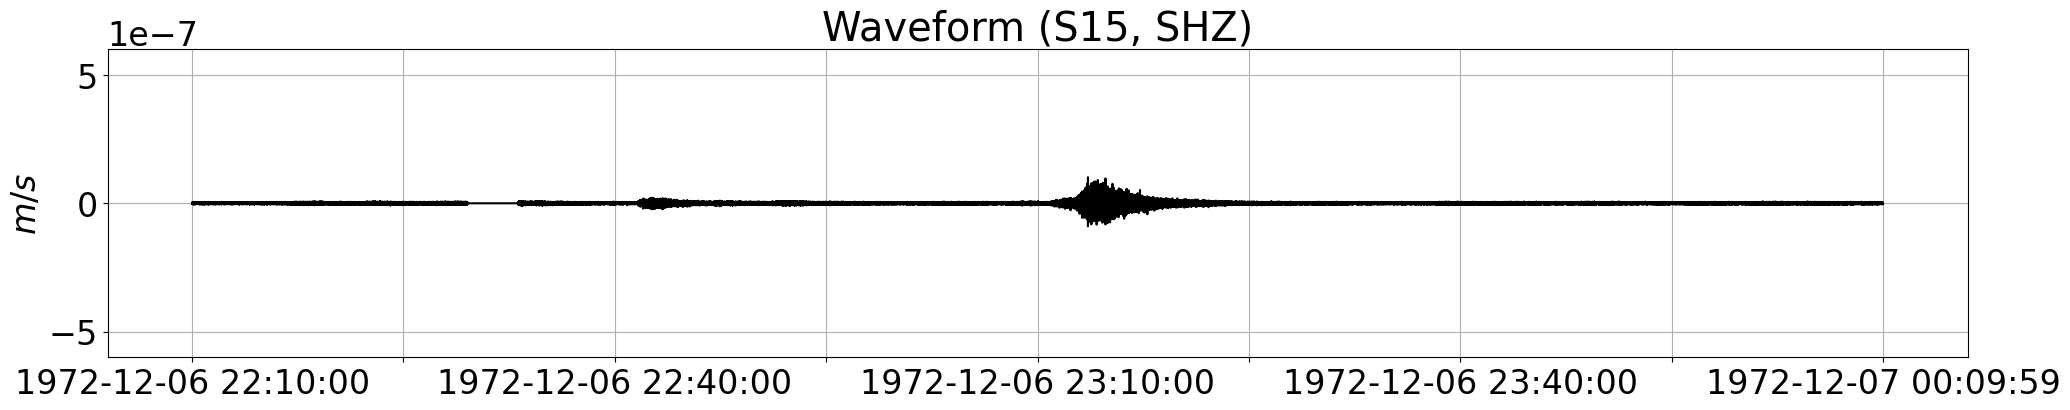

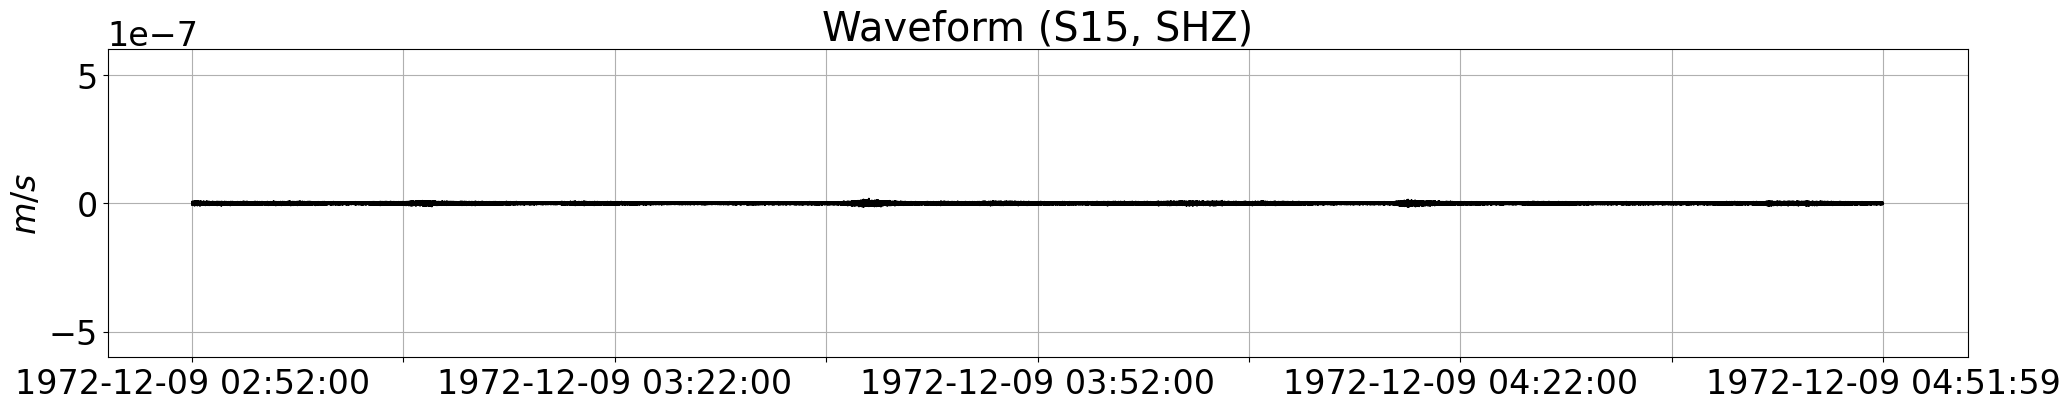

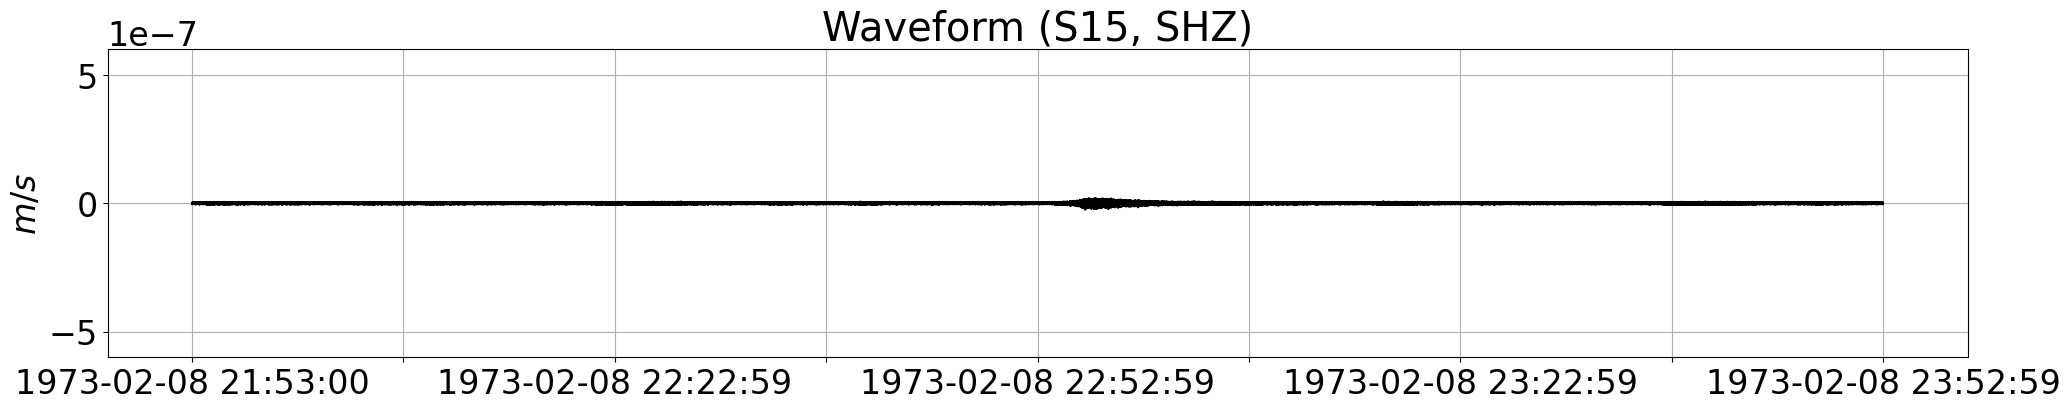

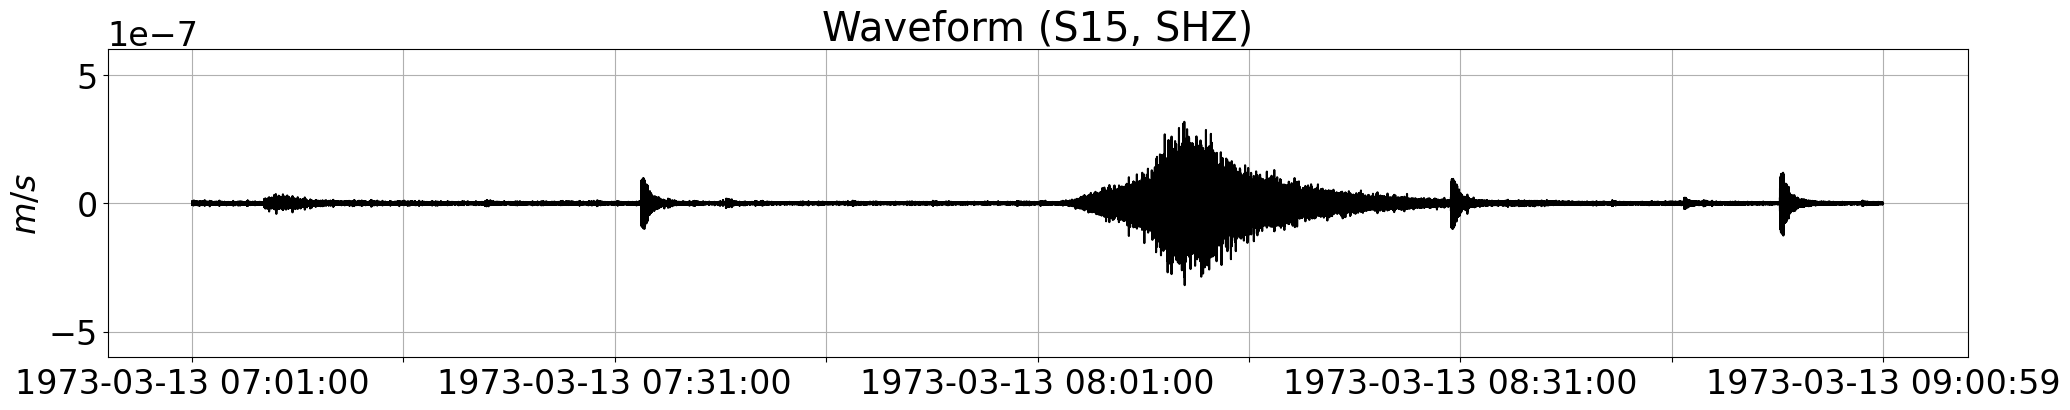

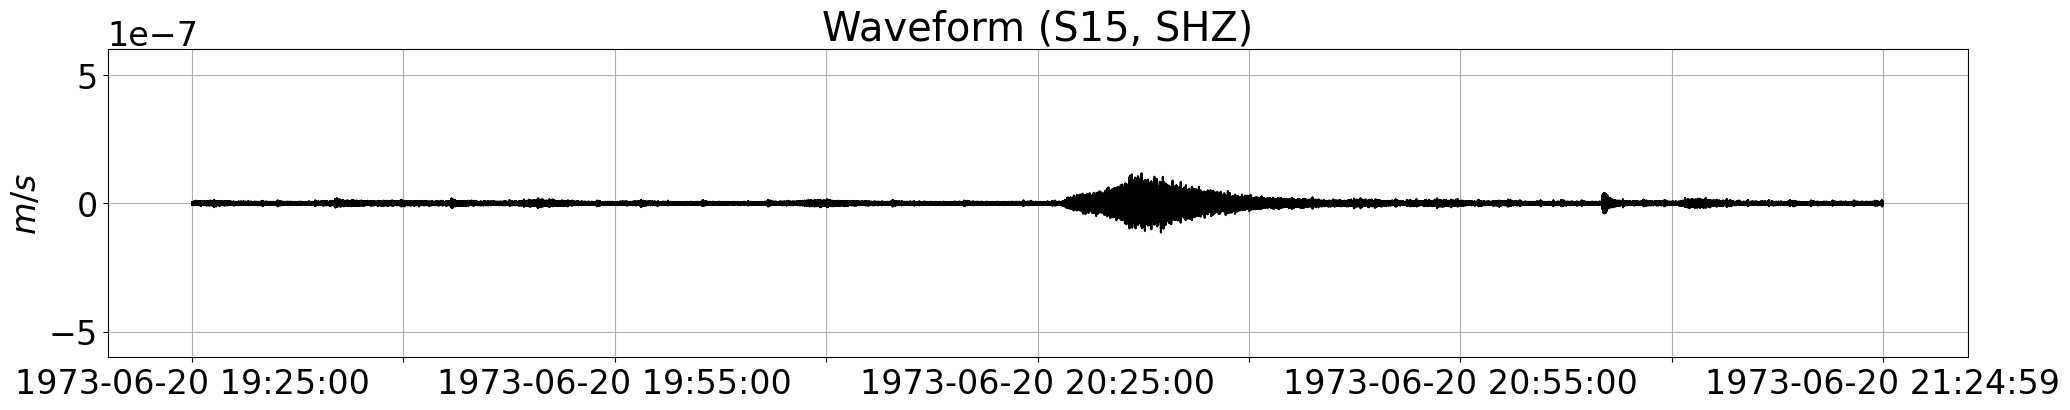

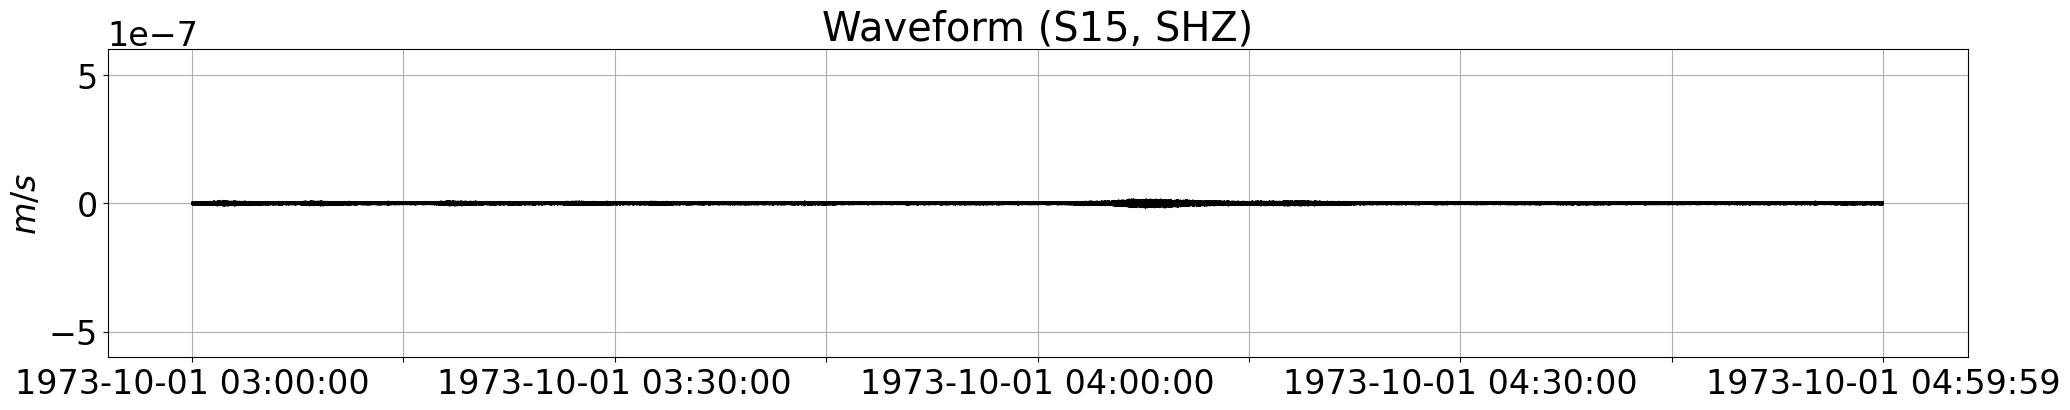

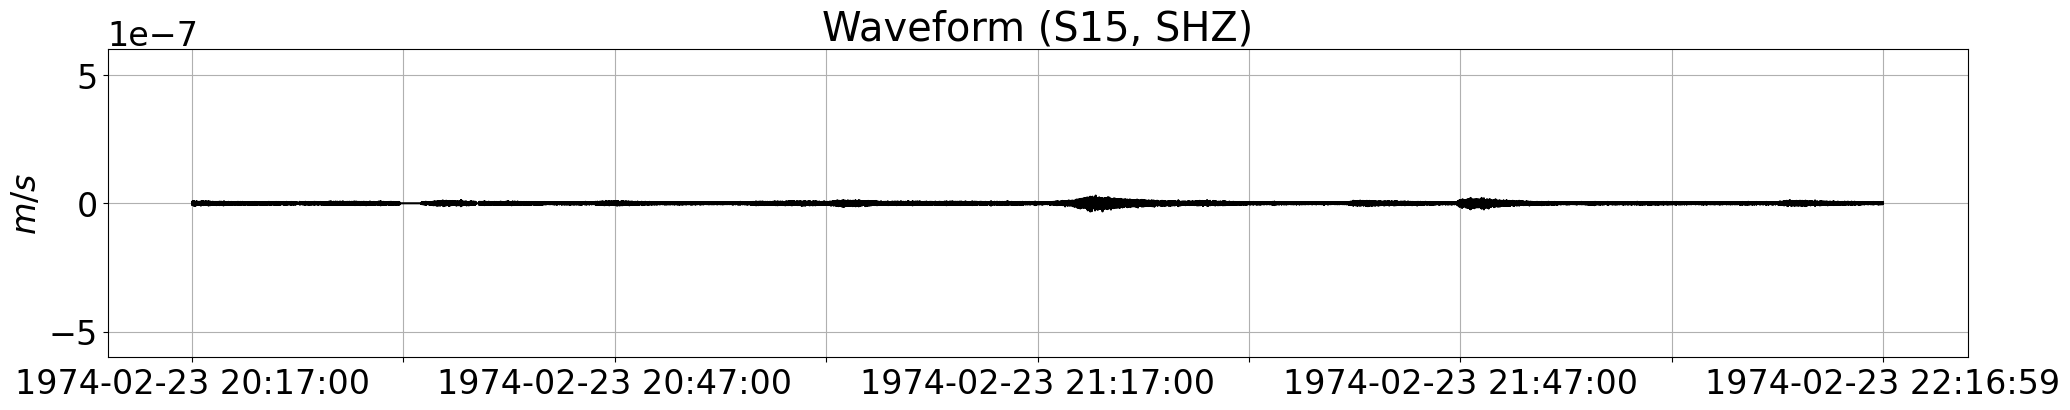

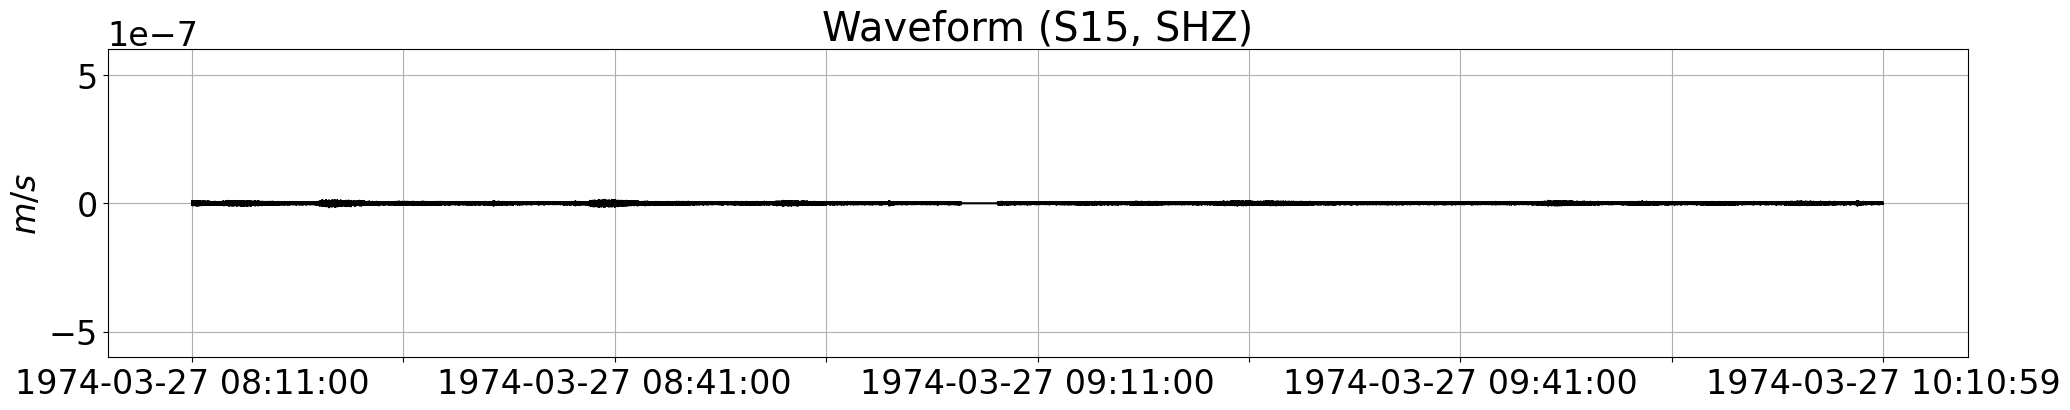

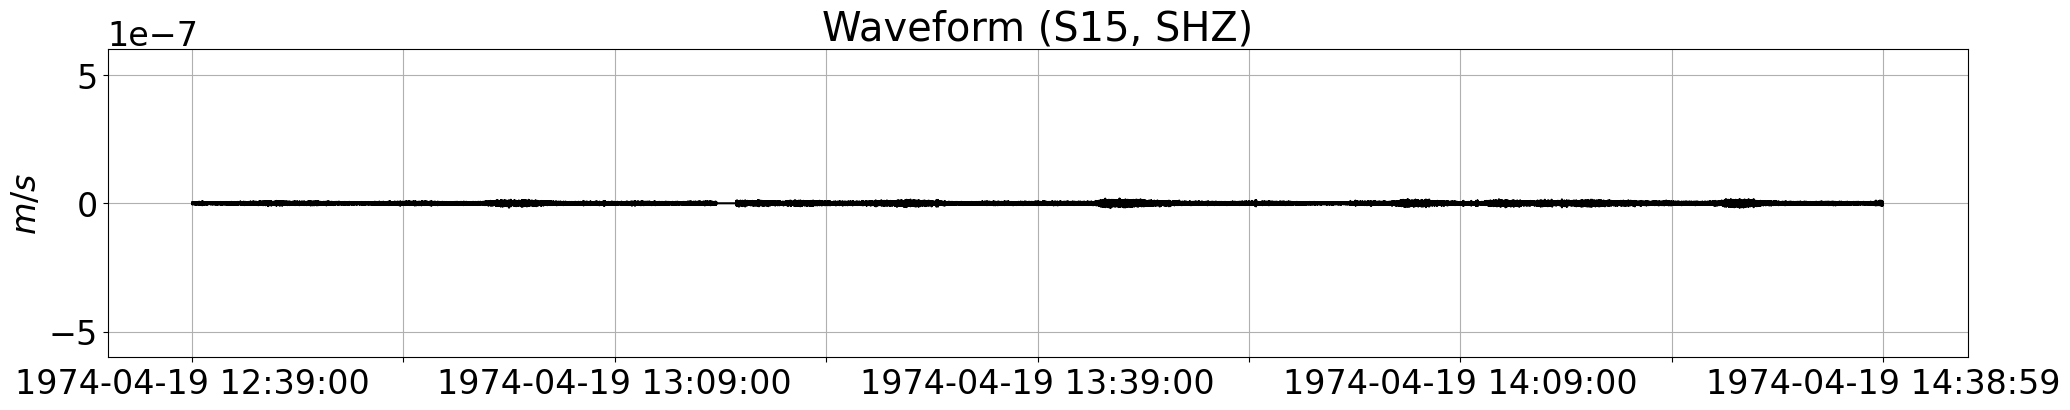

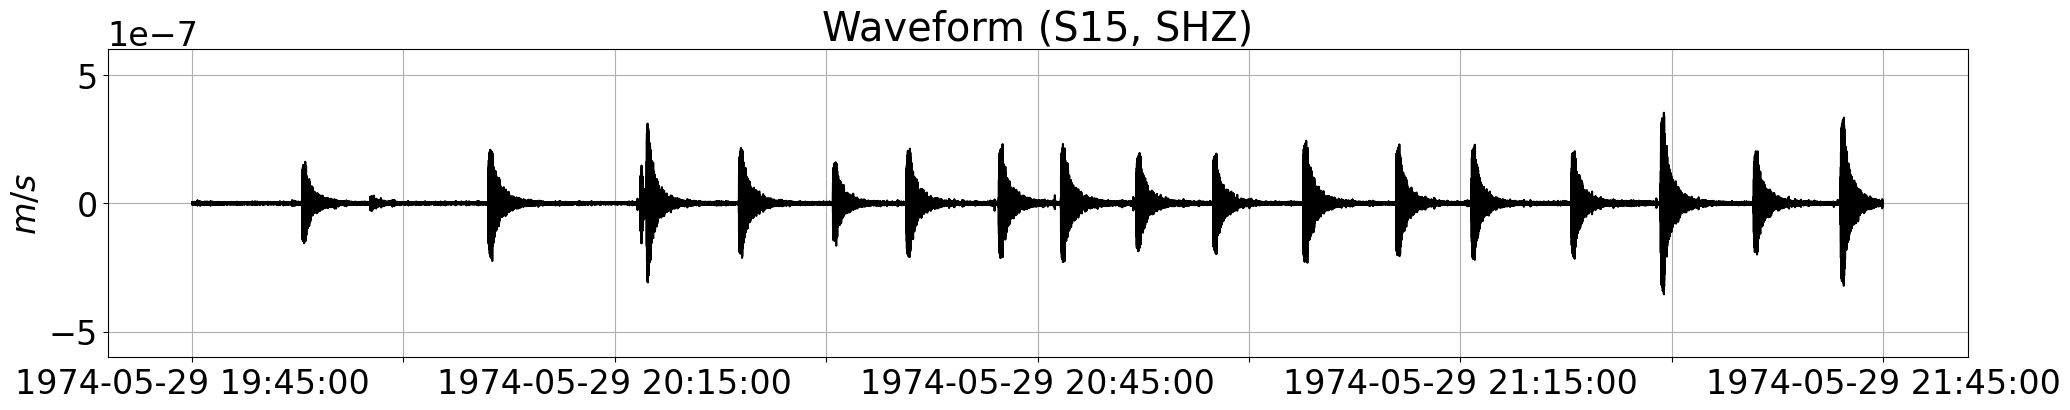

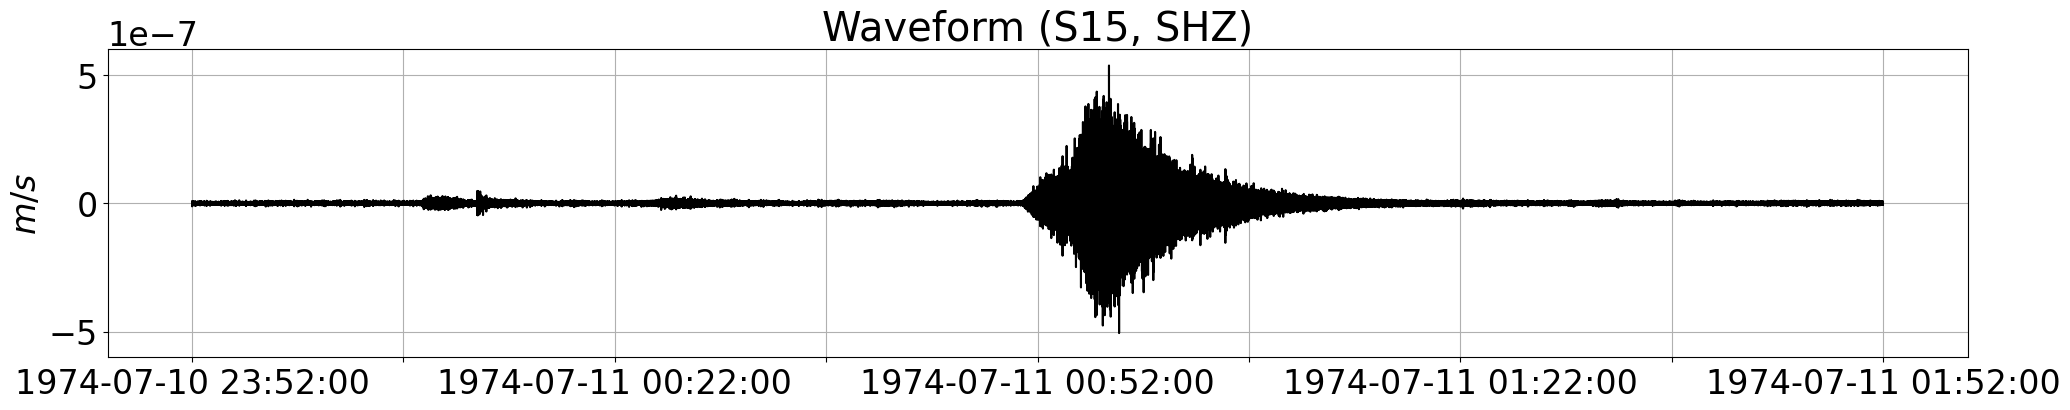

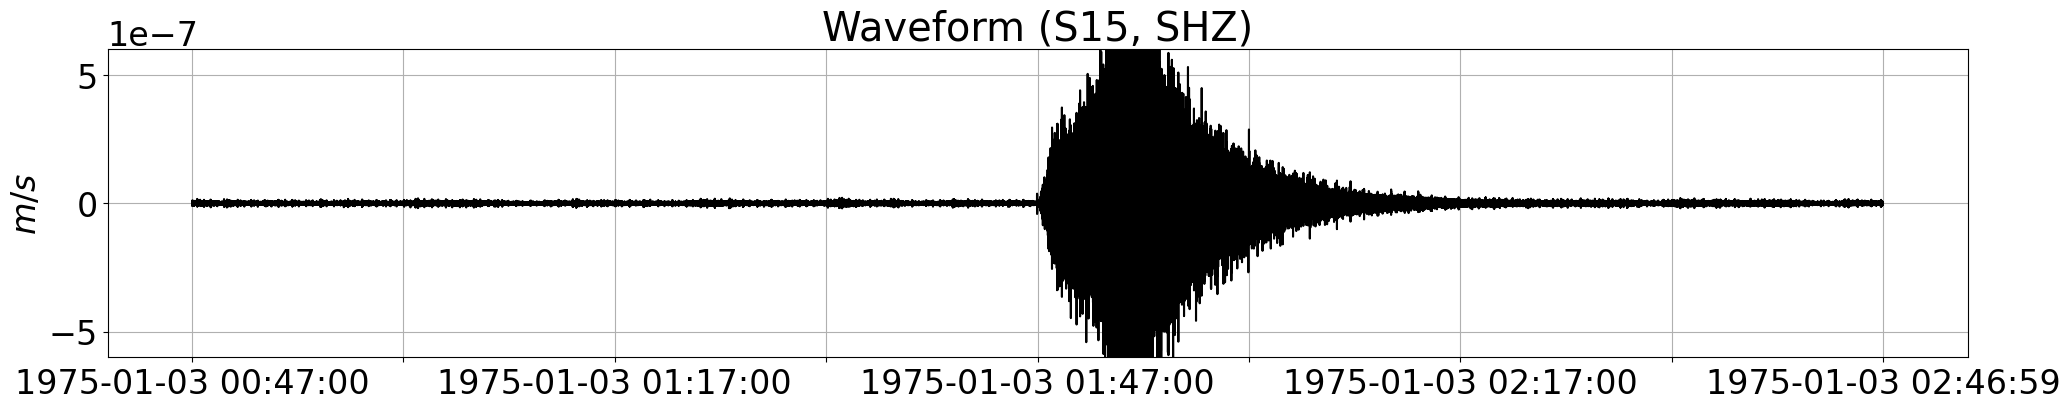

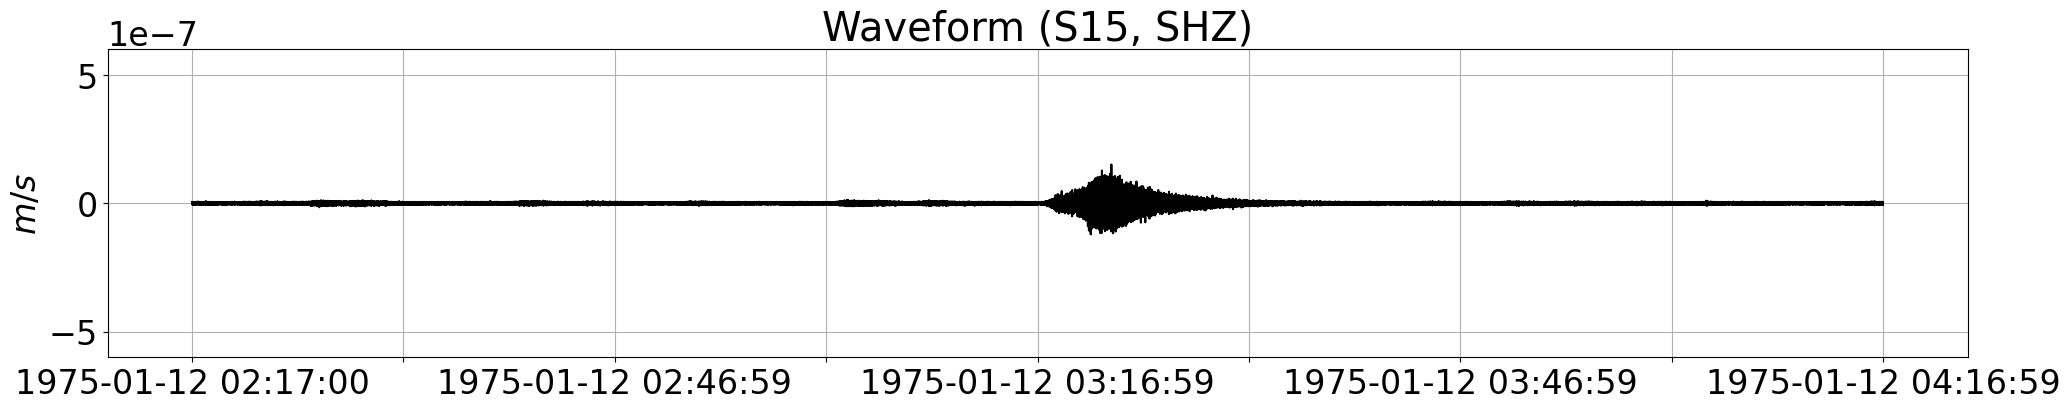

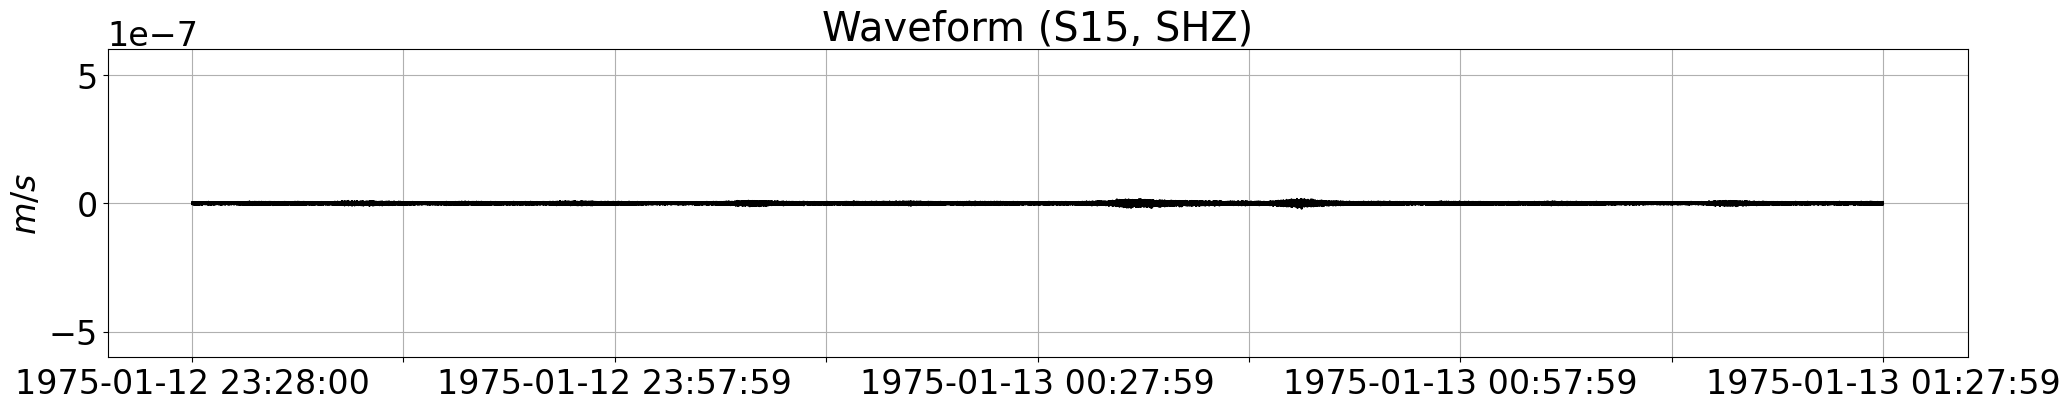

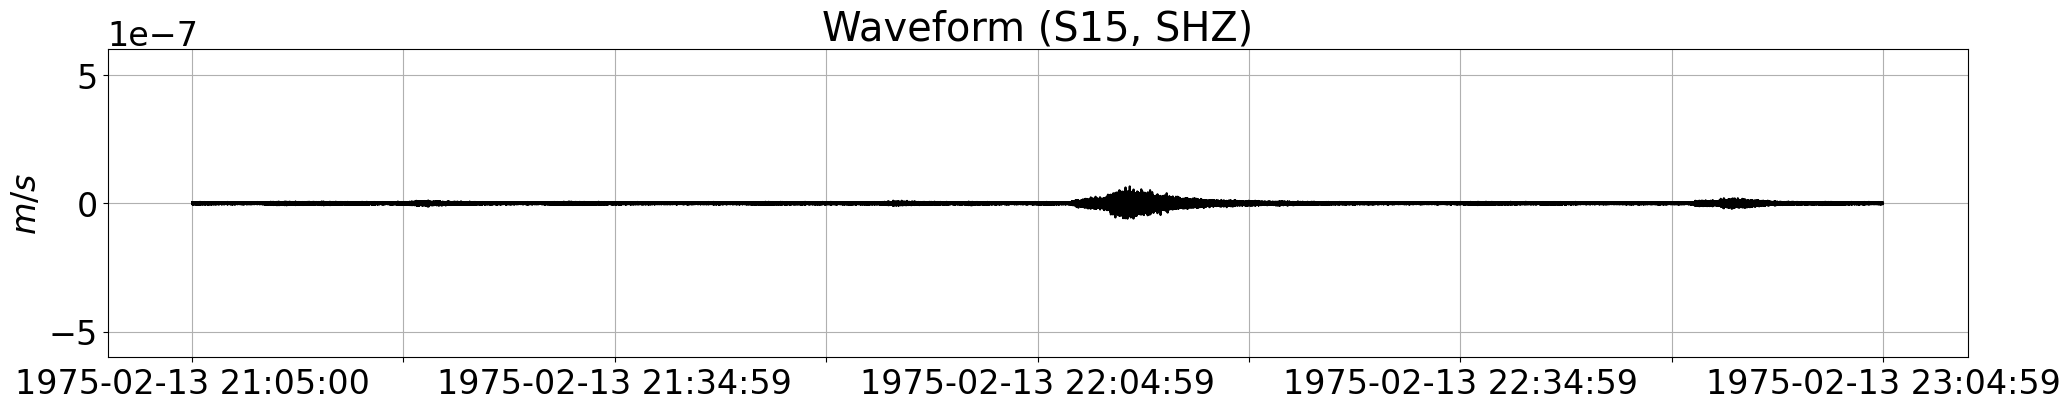

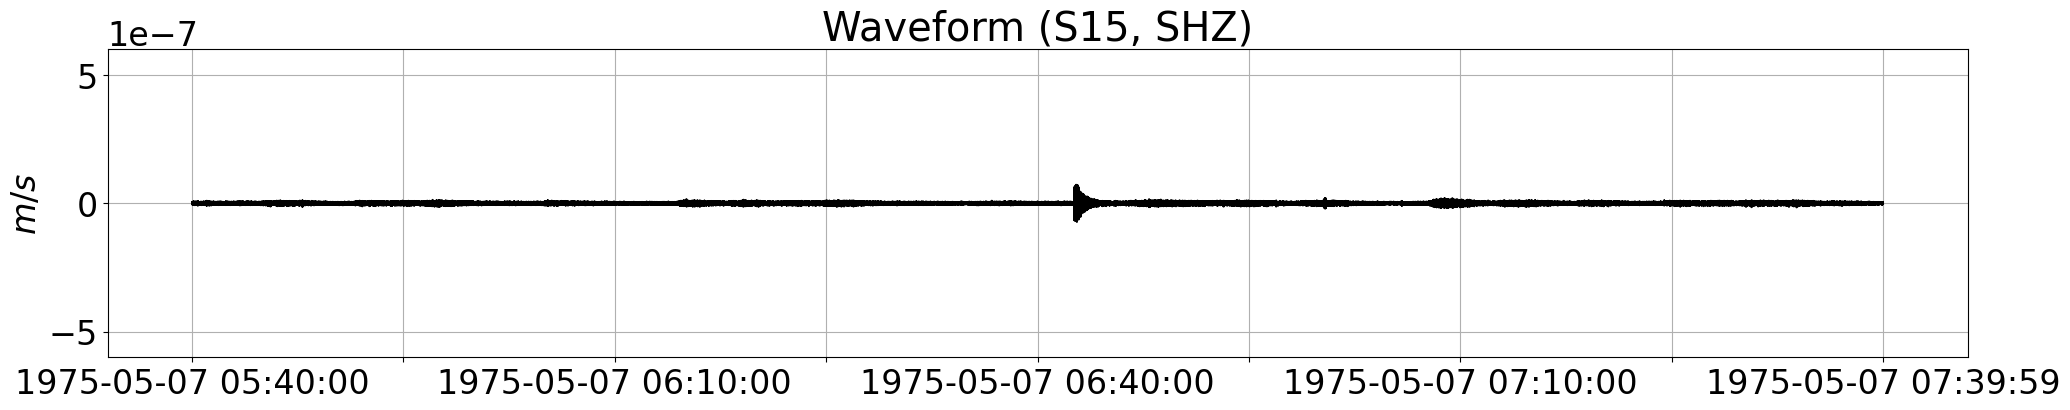

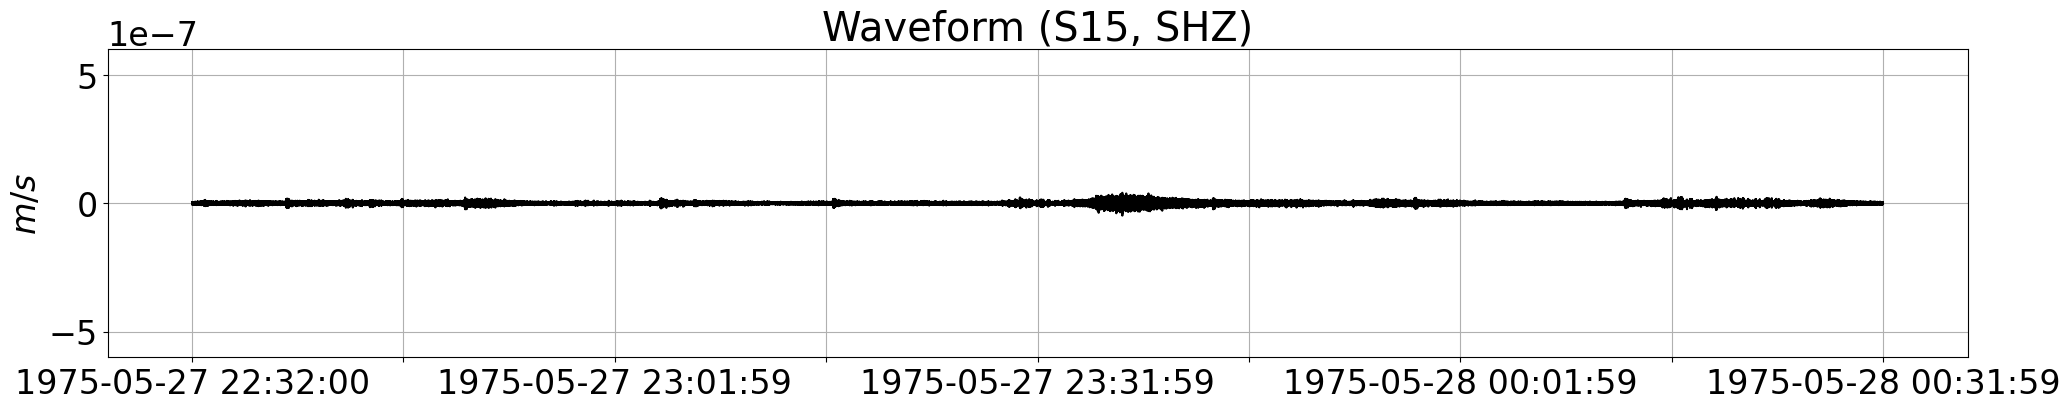

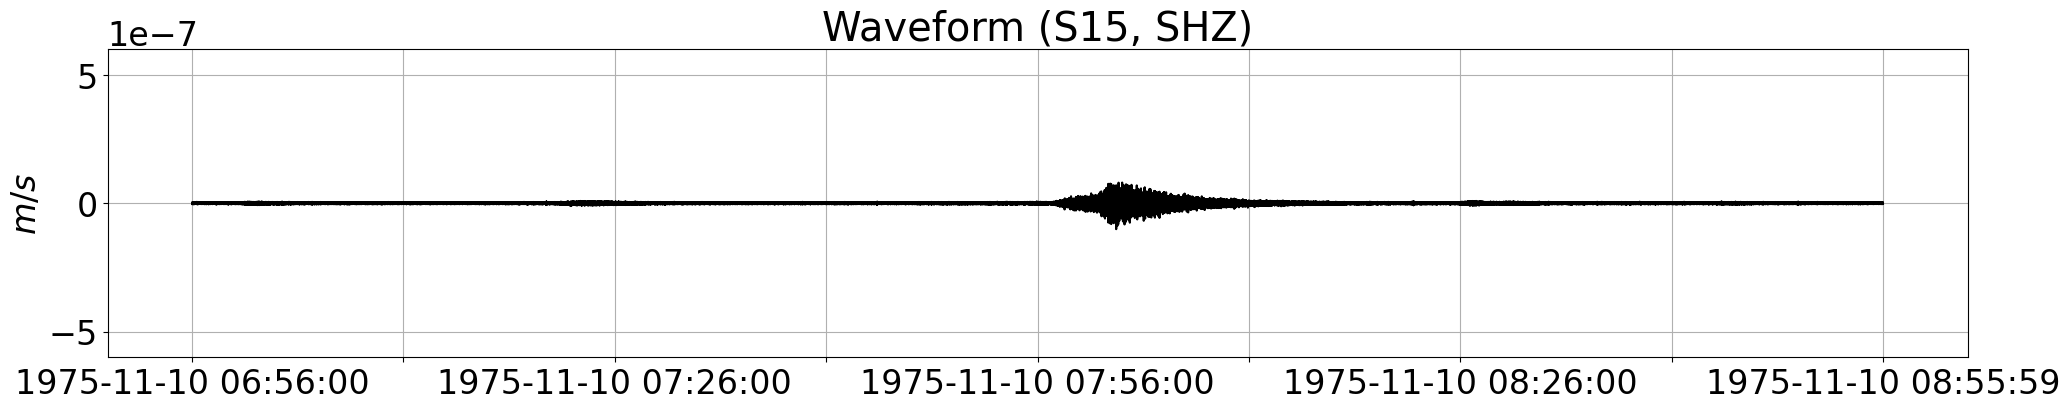

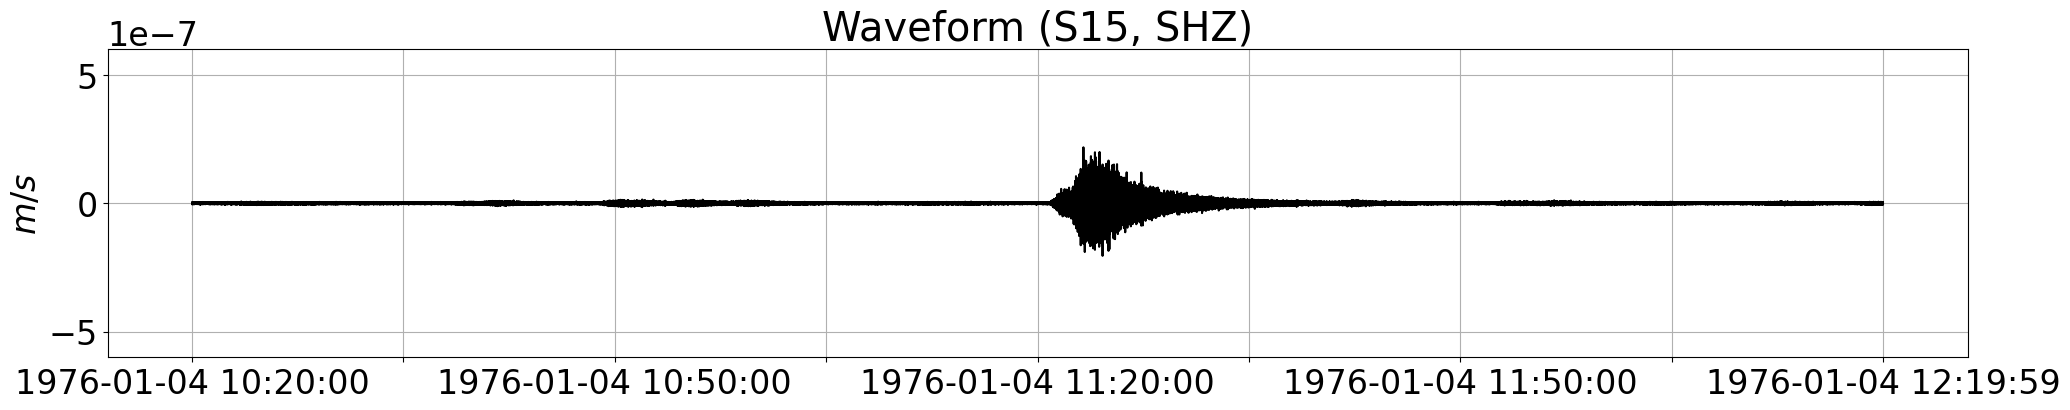

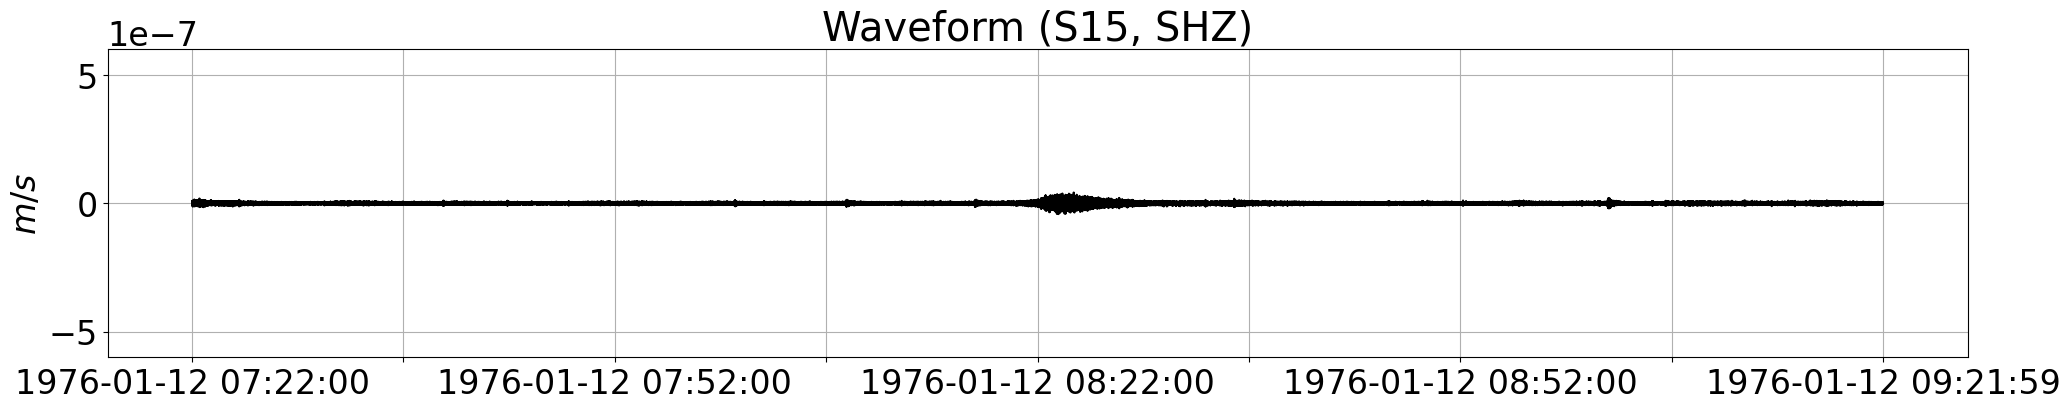

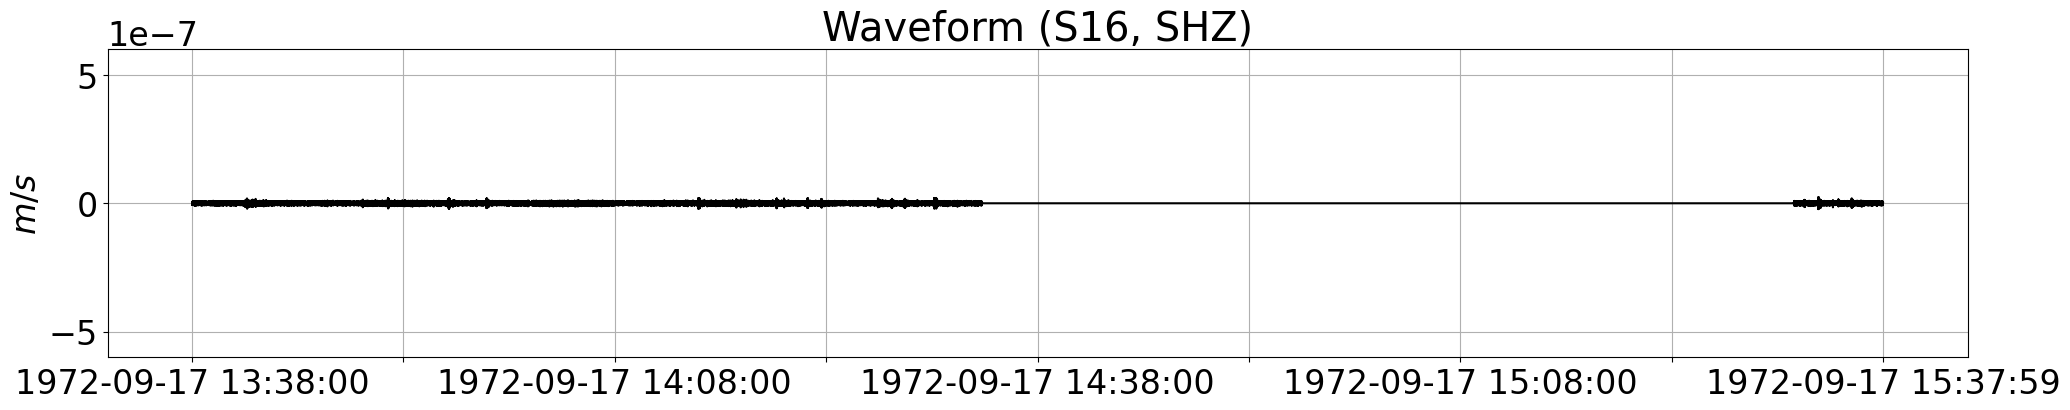

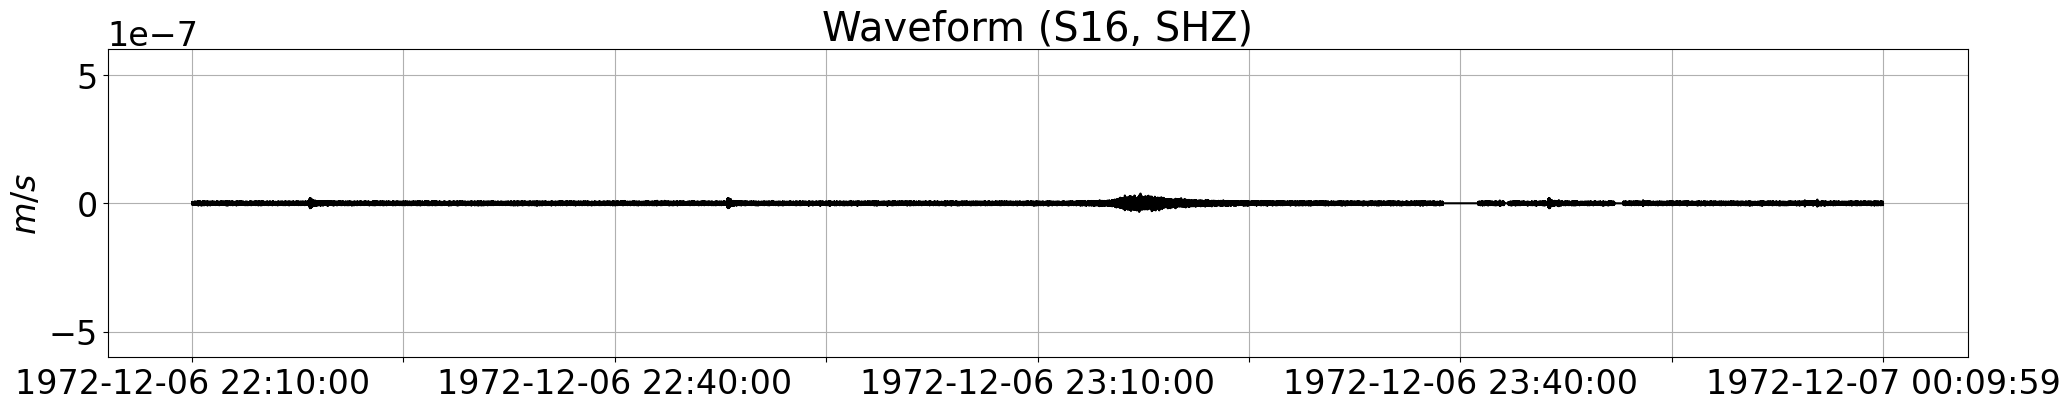

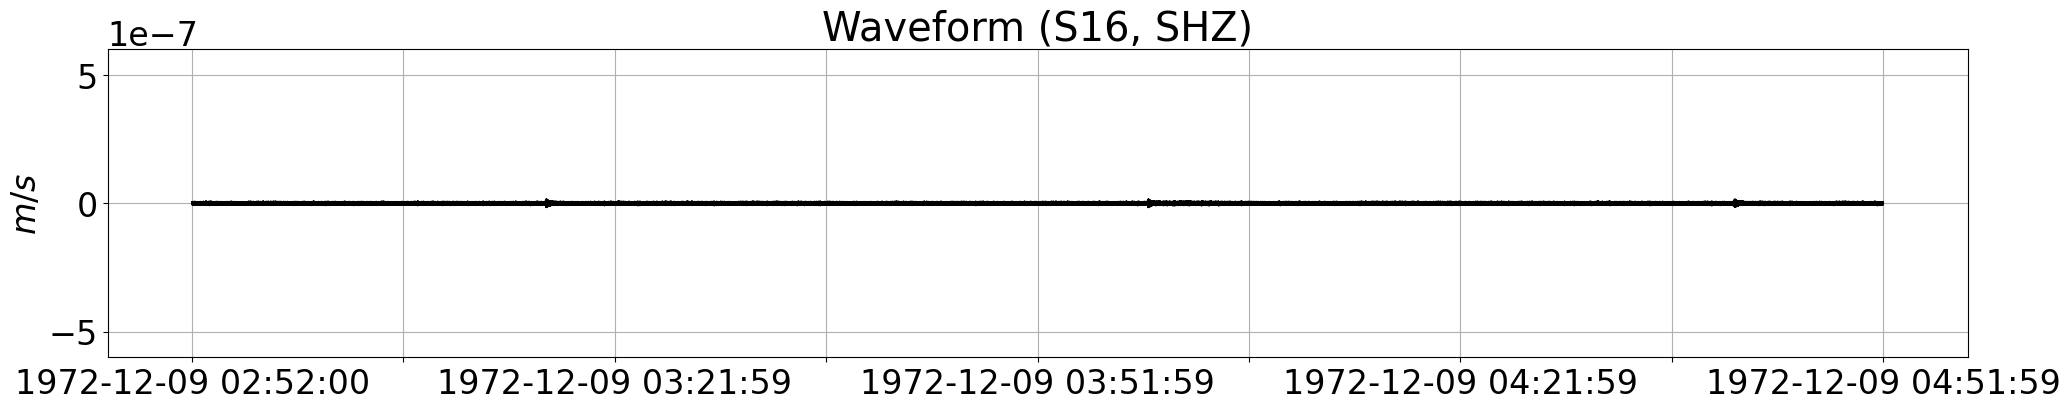

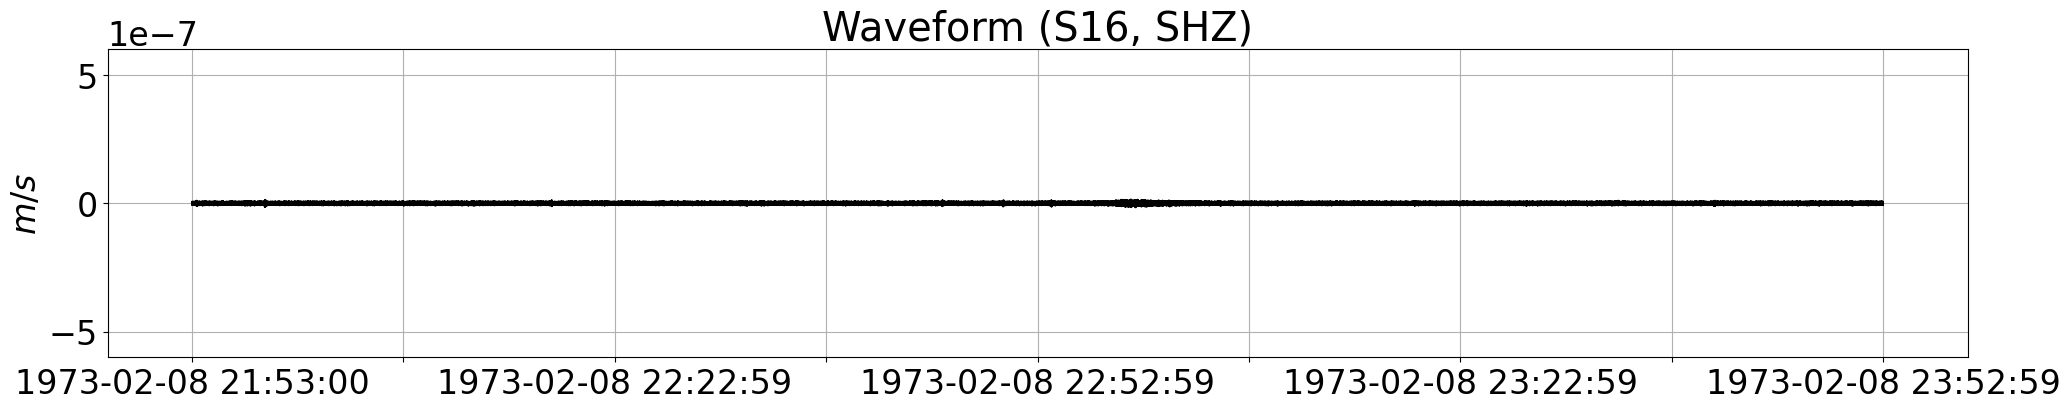

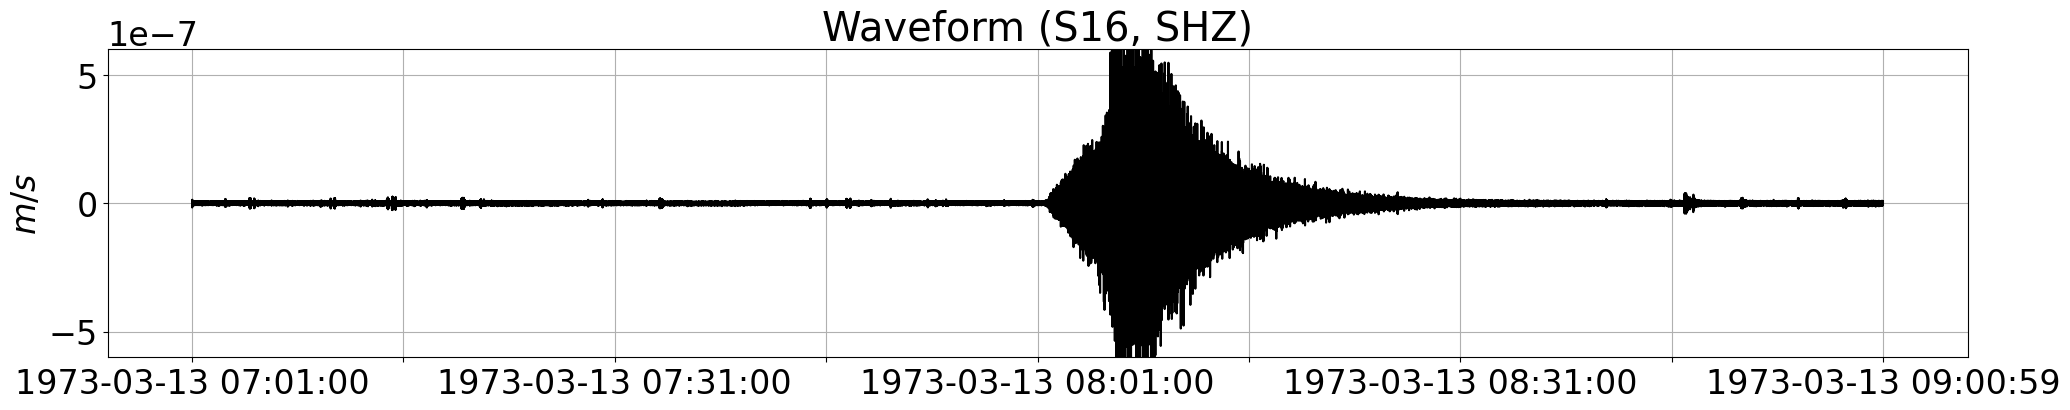

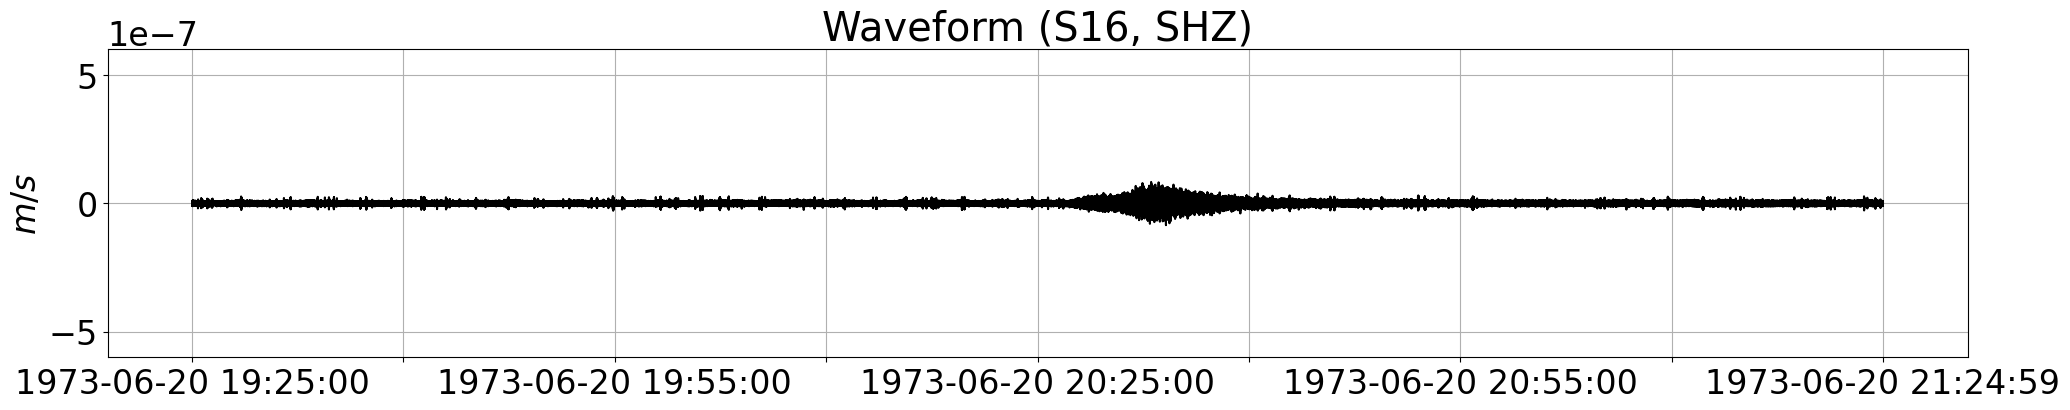

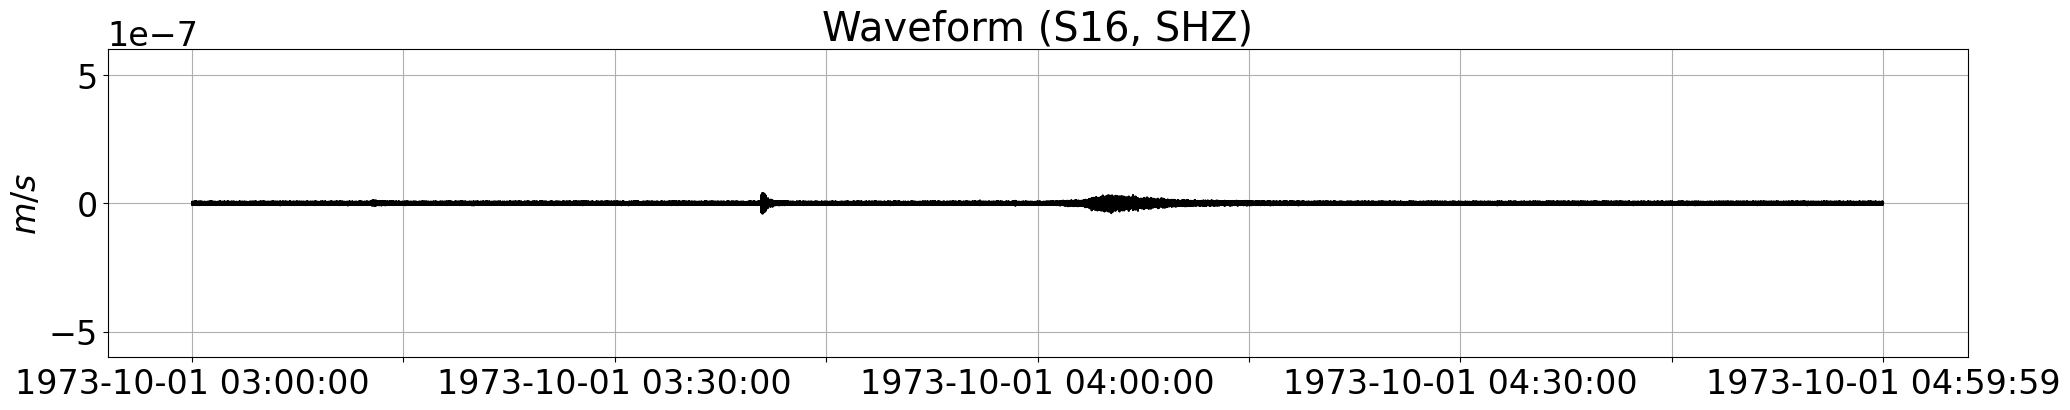

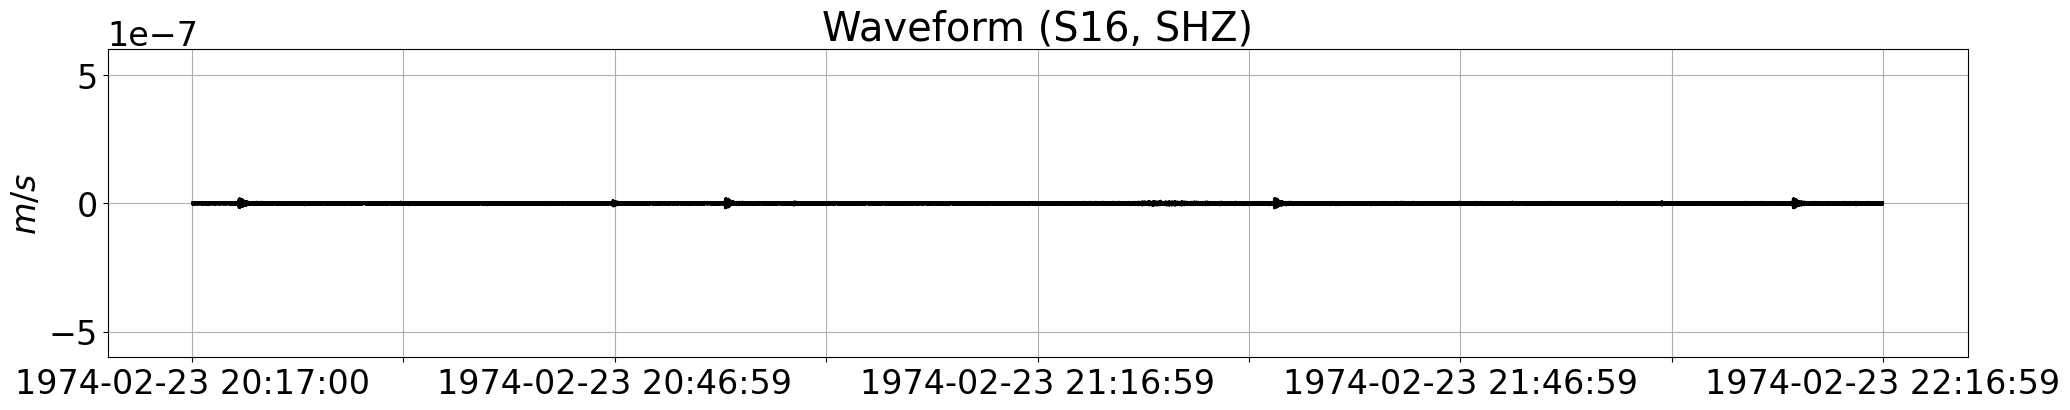

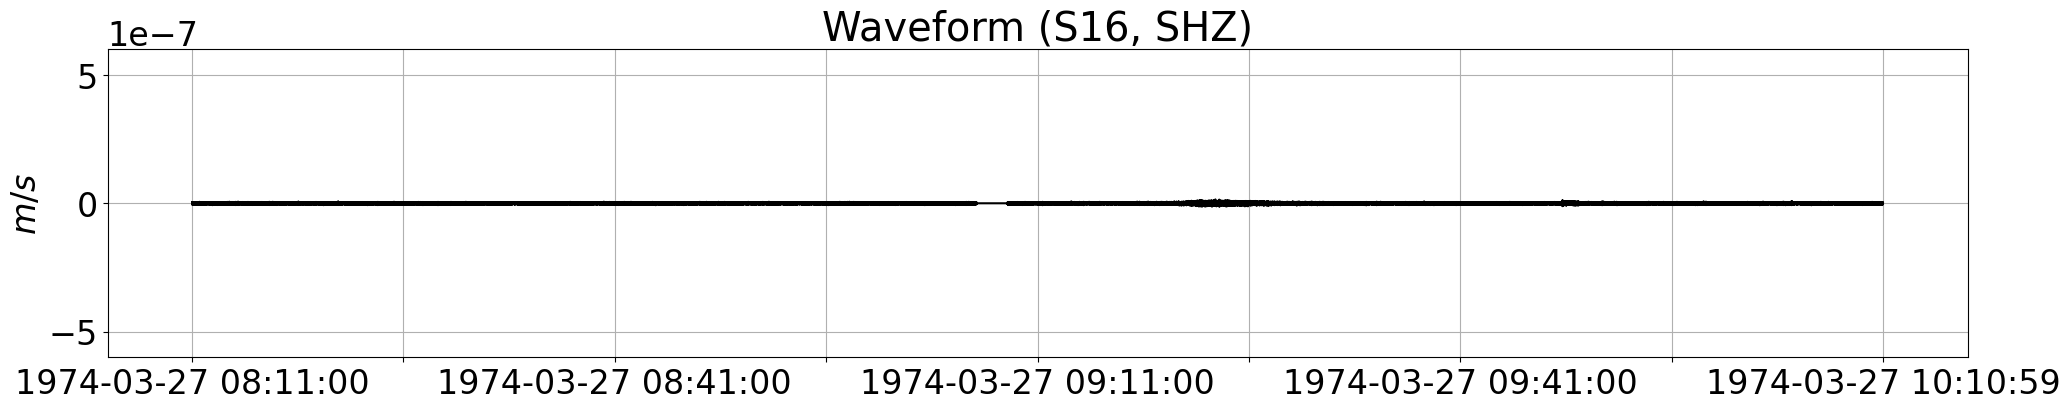

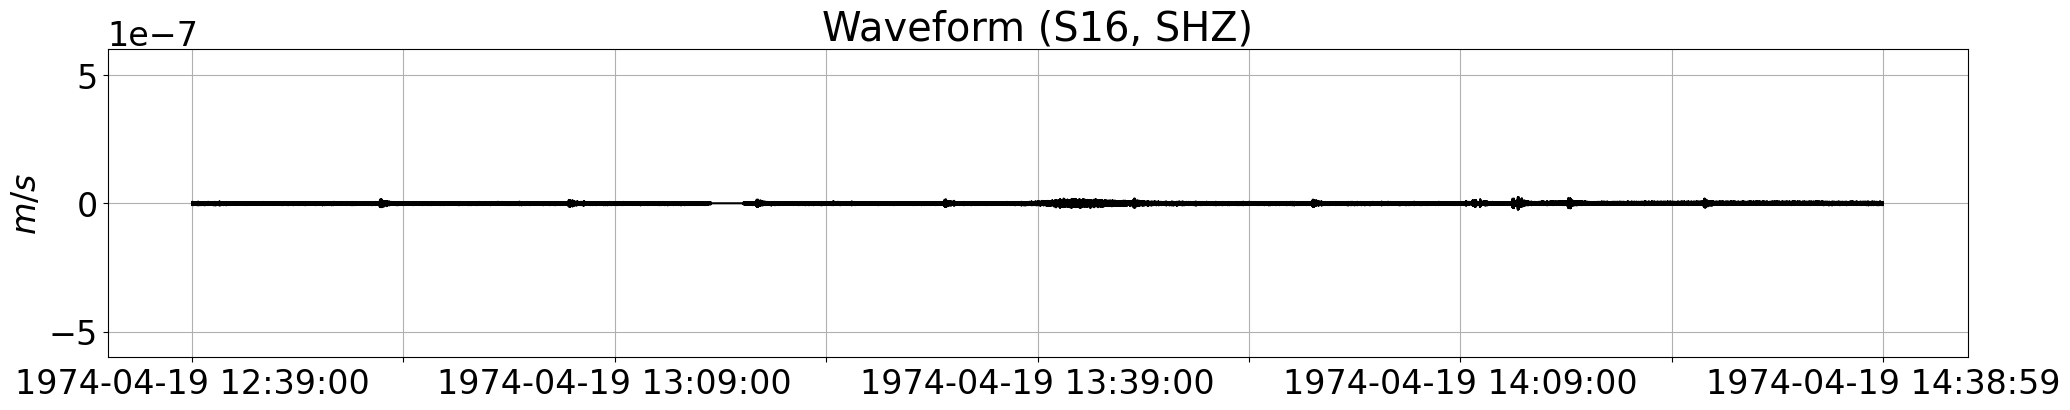

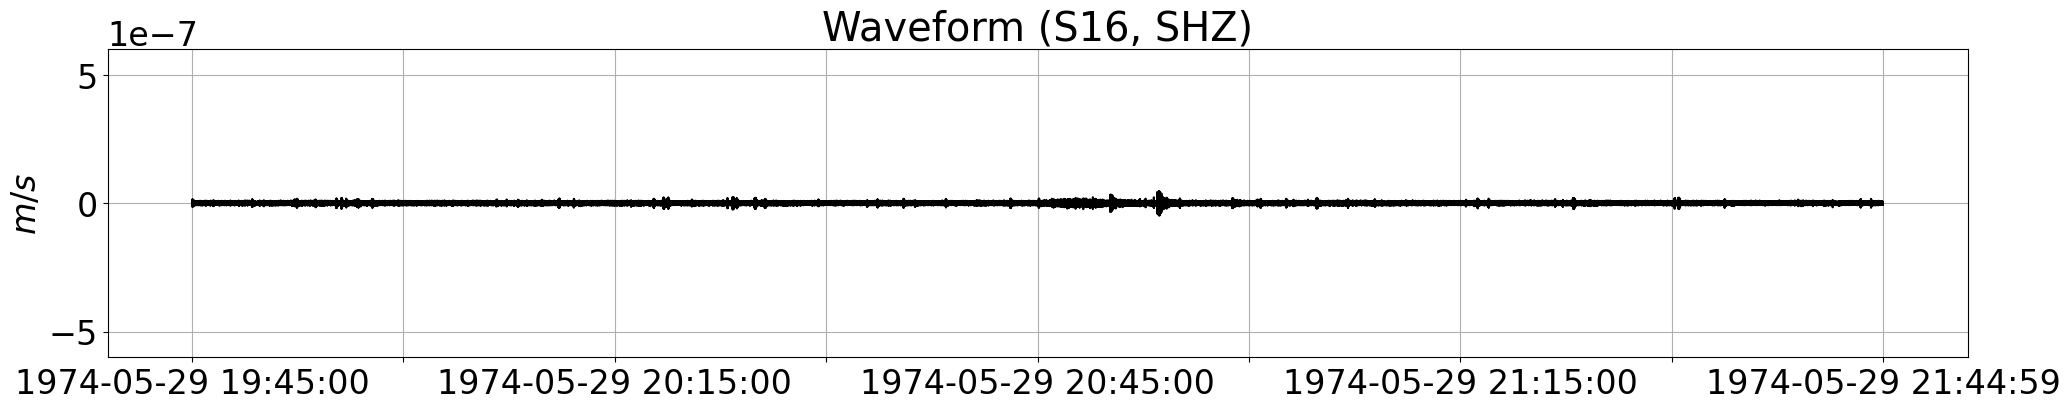

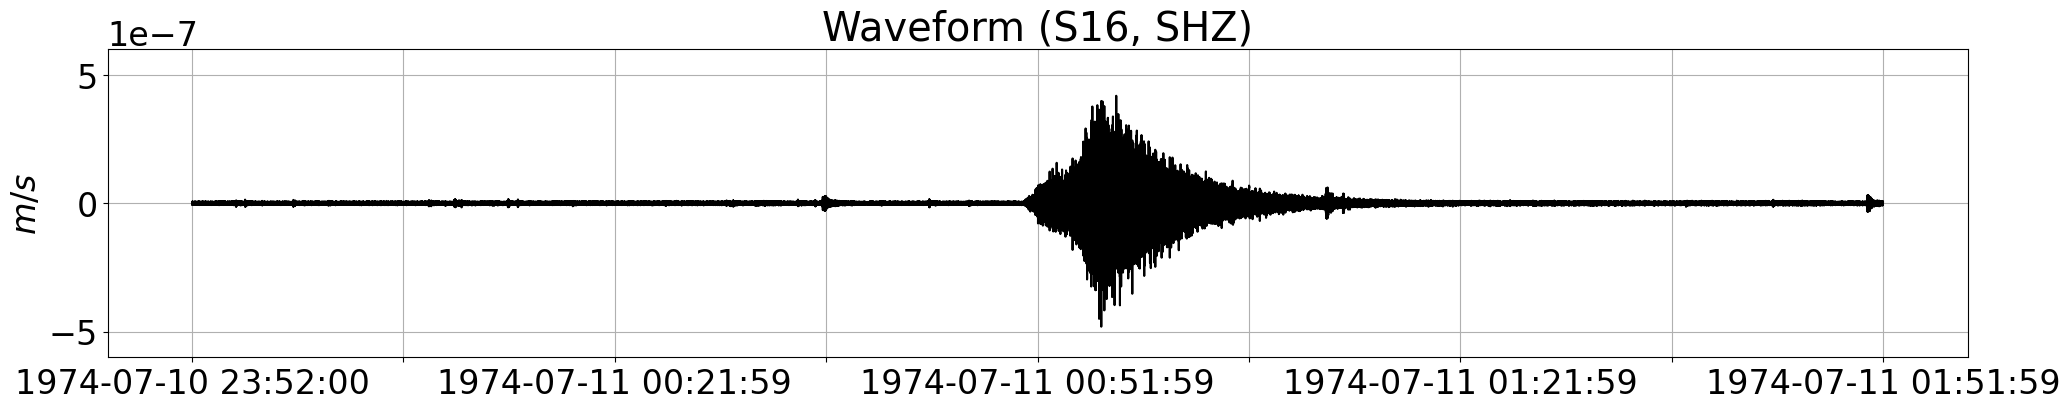

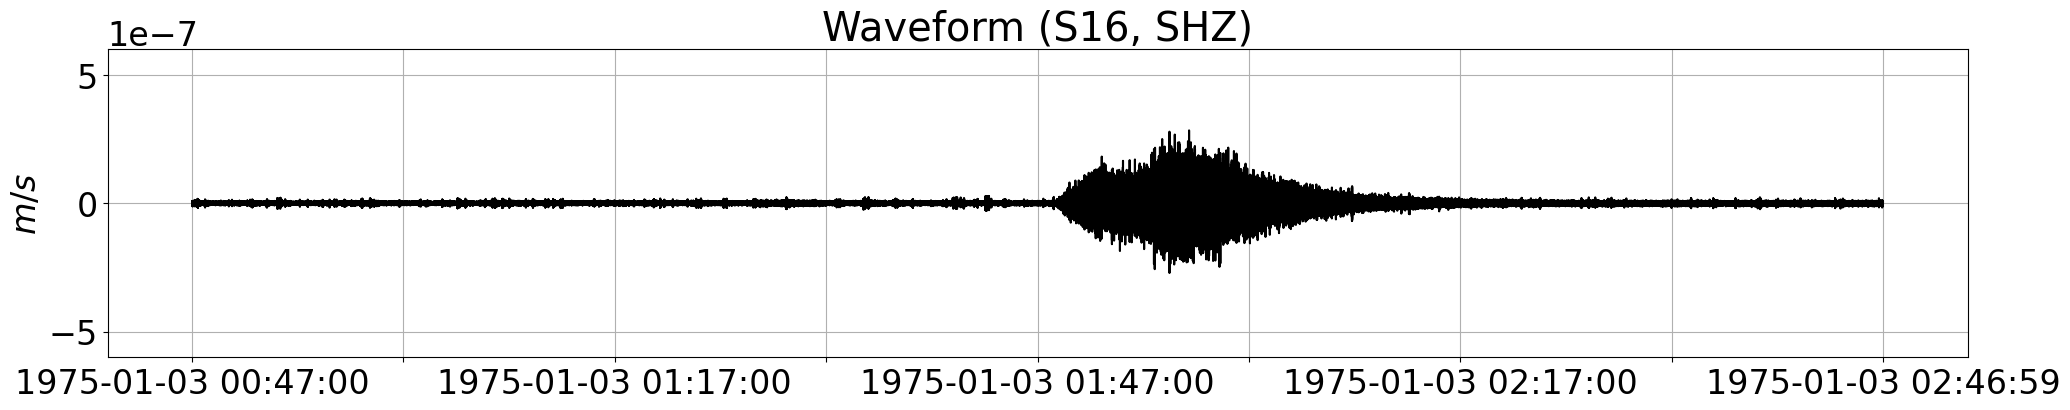

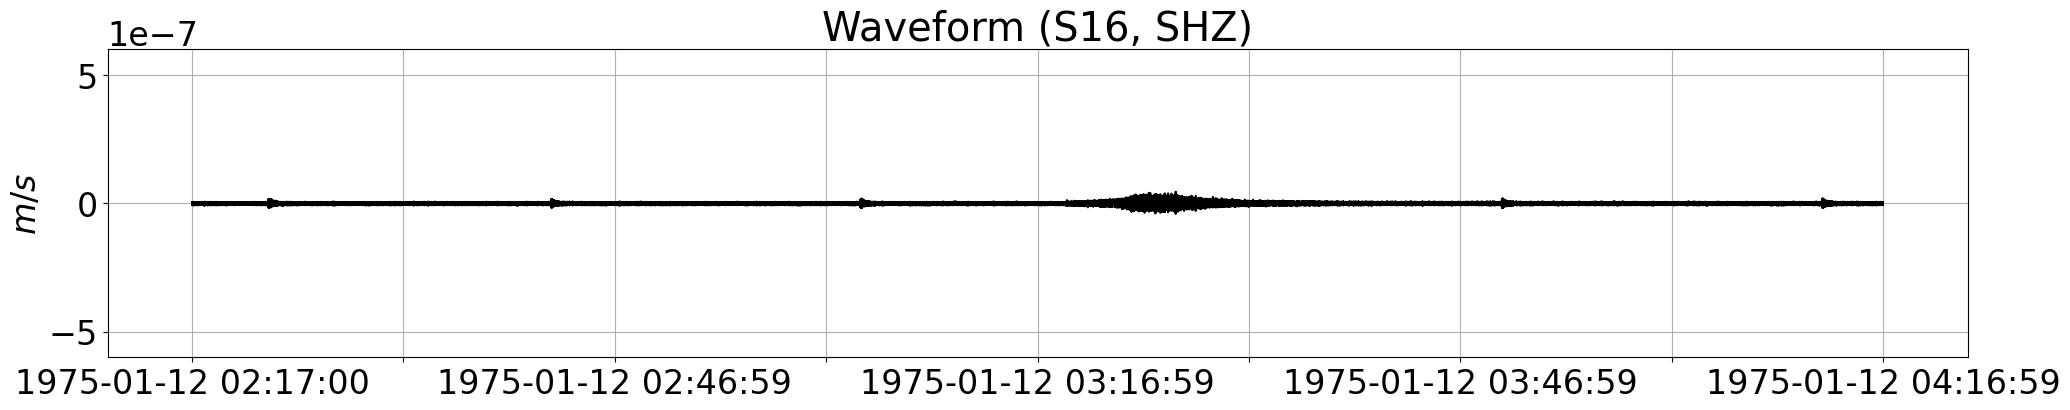

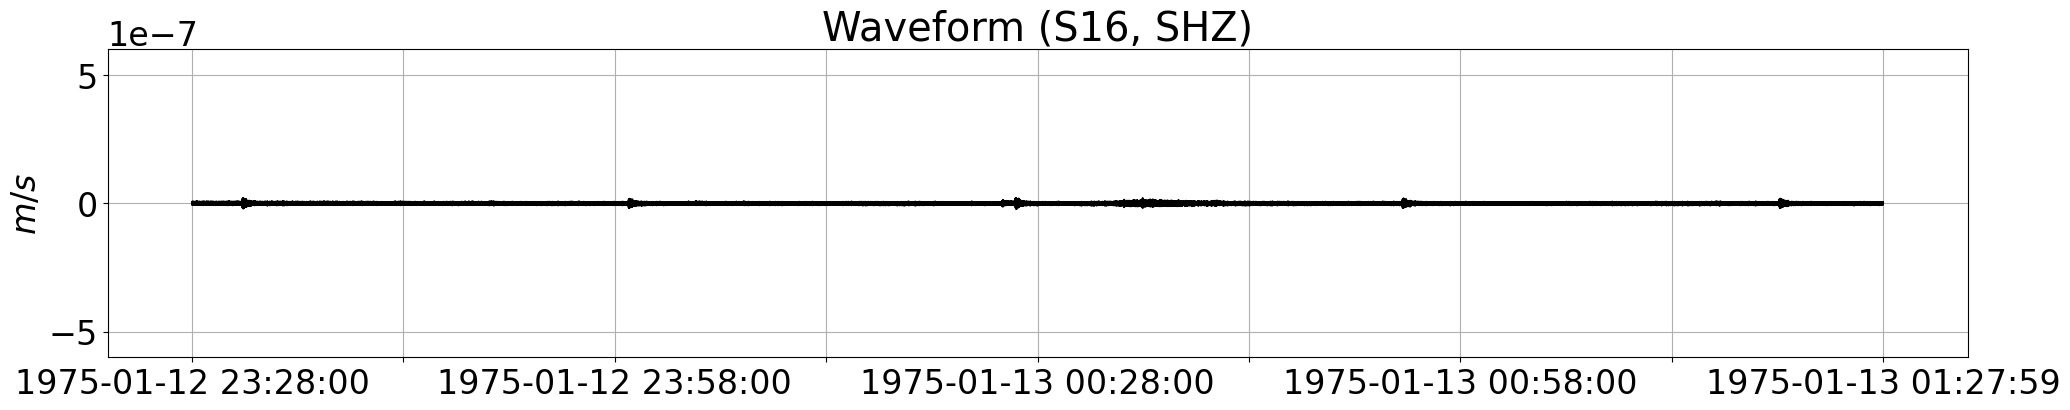

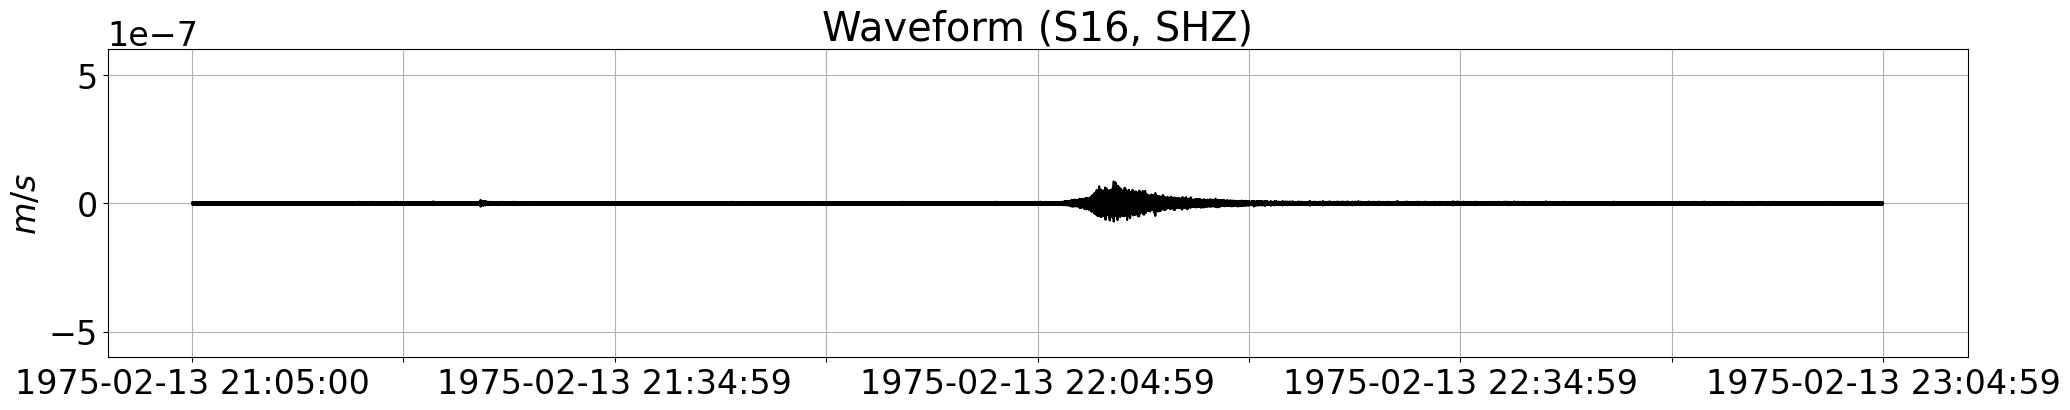

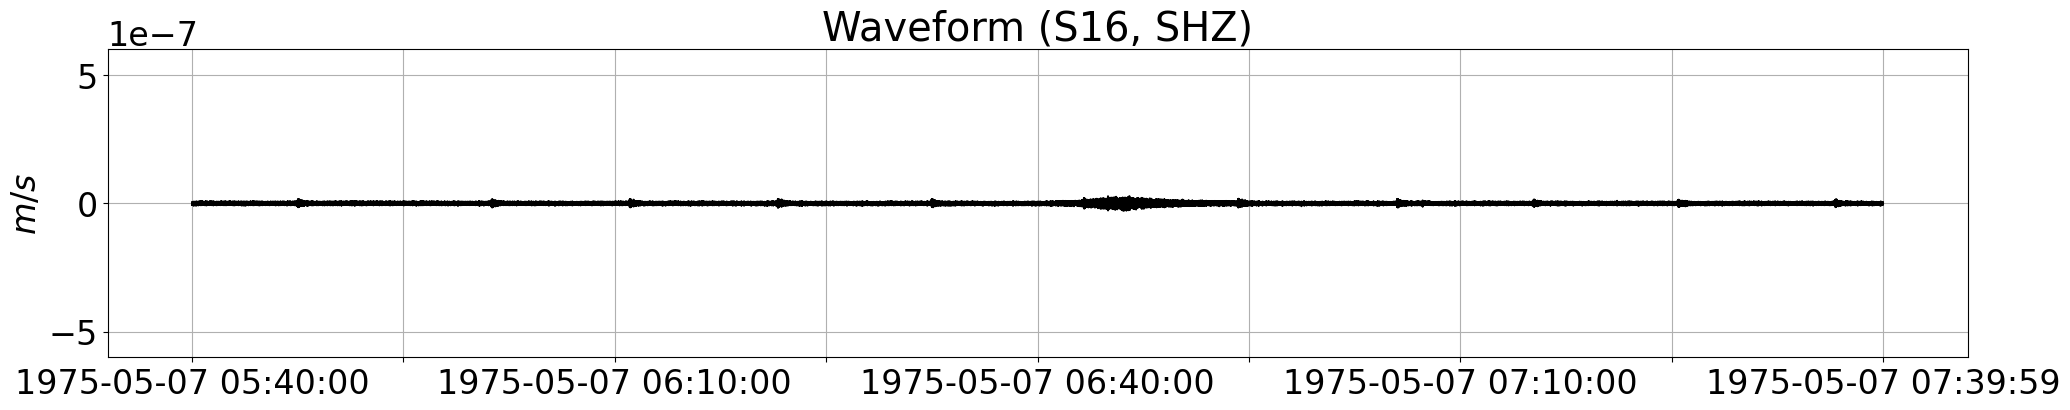

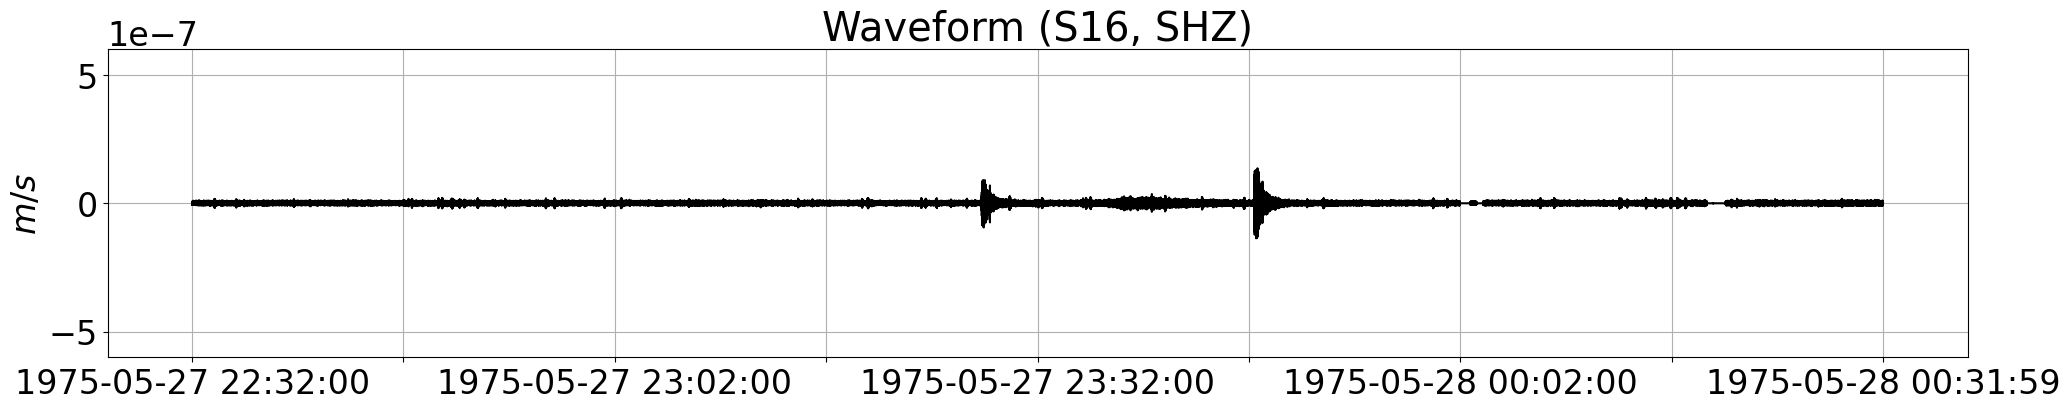

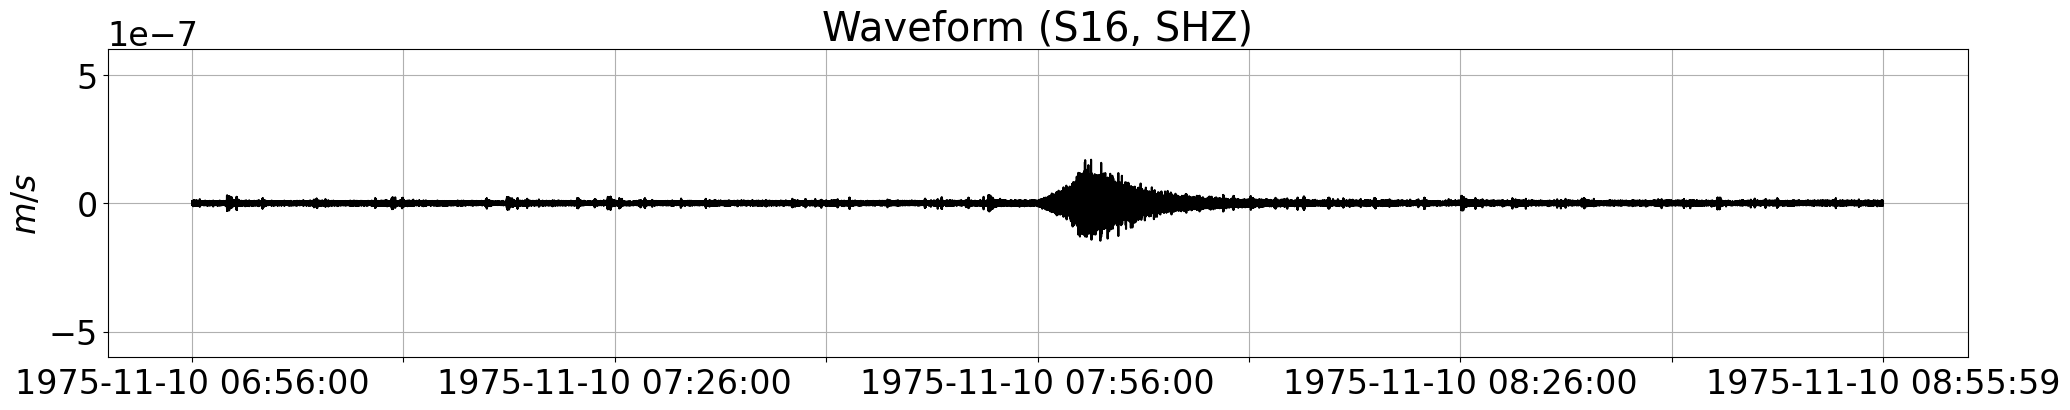

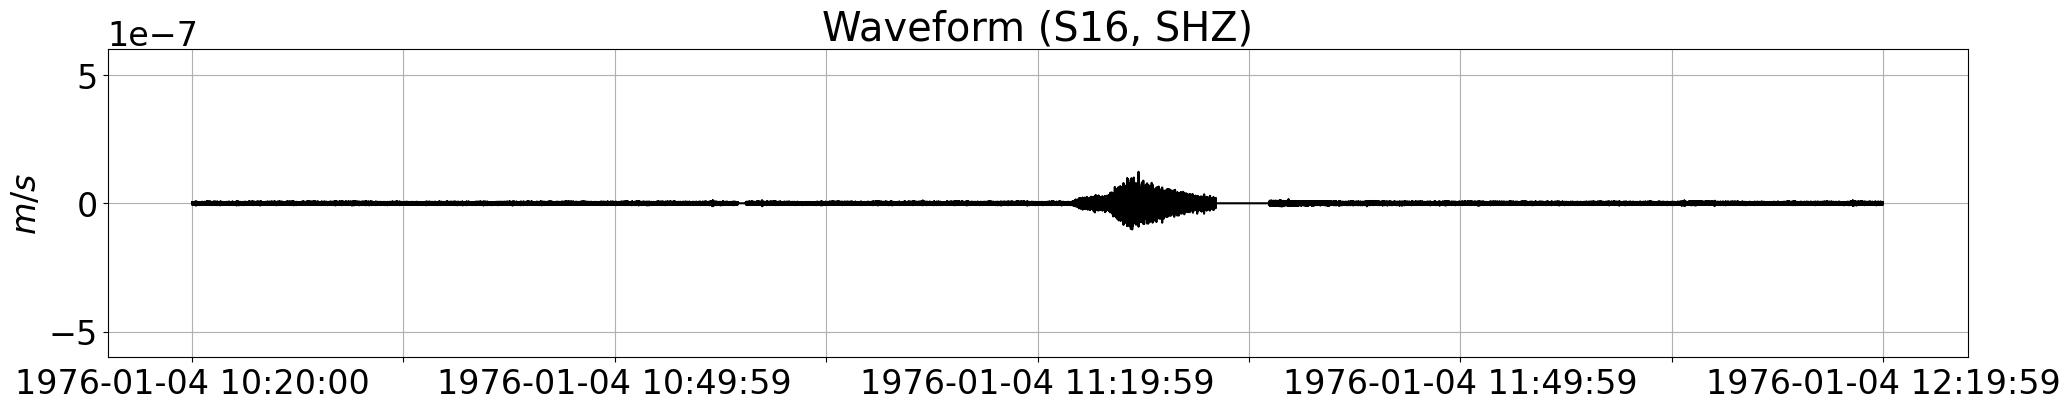

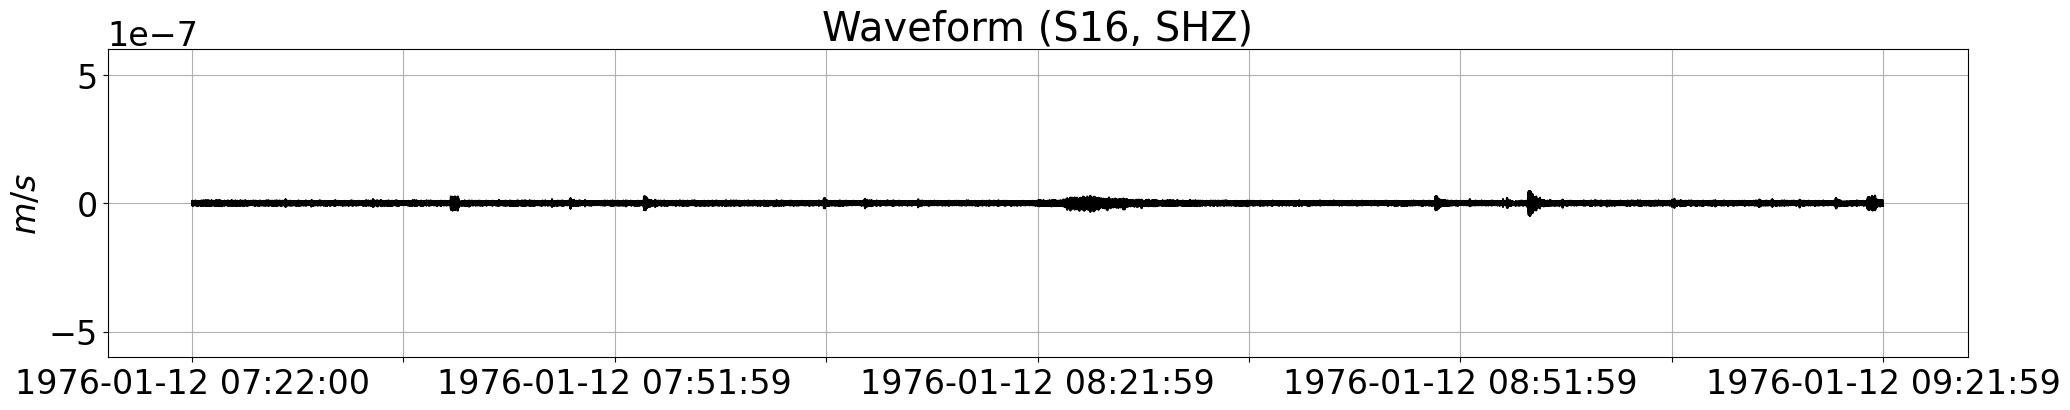

In [8]:
i = 4
for file in files[i:i+100]:
    with open(file, "rb") as p:
        st = pickle.load(p)

    sigma = np.std(st[0].data)
    st.trim(
        st[0].stats.starttime + timedelta(hours=11),
        st[0].stats.endtime - timedelta(hours=11),
    )
    plot_current_data(st)
    
    # N_SECONDS = 60
    # N_SAMPLES = int(st[0].stats.sampling_rate * N_SECONDS)  # window size
    # ENV_MUL, STD_MUL = 4, 8
    # envelope = (
    #     np.convolve(
    #         np.ones(N_SAMPLES) / N_SAMPLES, abs(signal.hilbert(st[0].data)), mode="same"
    #     )
    #     * ENV_MUL
    #     + np.var(st[0].data) * STD_MUL
    # )

    # plt.figure(figsize=(24, 8))
    # plt.plot(st[0].data)
    # plt.hlines(2*sigma, 0, len(st[0].data), color="red")
    # plt.plot(envelope)
    # plt.ylim(-0.1e-6, 0.1e-6)
    # plt.show()